In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import multirecording_spikeanalysis as spike

# Load the DataFrame using pandas
rce3_alone_clusters = pd.read_pickle("rce_pilot_3_alone_comp_cluster_ranges.pkl")

# Initialize the dictionary
timestamp_dicts = {}

# Loop through each row of the DataFrame to populate the dictionary
for index, row in rce3_alone_clusters.iterrows():
    # Define the key as a combination of session_dir and current_subject
    key = f"{row['session_dir']}"

    start_pos = key.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    key_without_suffix = key[:end_pos]
    
    # Initialize nested dictionary for this key if not already present
    if key not in timestamp_dicts:
        timestamp_dicts[key_without_suffix] = {}

    # Loop through the cluster_timestamps_ranges_dict to populate conditions
    for condition, ranges in row['cluster_timestamps_ranges_dict'].items():
        # Check if the condition key already exists, if not initialize a list
        if condition not in timestamp_dicts[key_without_suffix]:
            timestamp_dicts[key_without_suffix][str(condition)] = []

        # Extend the existing list with new ranges
        modified_ranges = [(start // 20, end // 20) for start, end in ranges]
        timestamp_dicts[key_without_suffix][str(condition)].extend(modified_ranges)

# Optionally, convert the lists to numpy arrays as in your previous code
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)

In [2]:
# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'recordings' / 'behav_clust'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
20240320_171038_alone_comp_subj_4-2_t6b6_merged.rec
<class 'numpy.ndarray'>
20240322_160946_alone_comp_subj_4-3_t6b6_merged.rec
<class 'numpy.ndarray'>
20240323_122227_alone_comp_subj_5-2_t6b6_merged.rec
<class 'numpy.ndarray'>
20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec
Please assign event dictionaries to each recording
as recording.event_dict
event_dict = {event name(str): np.array[[start(ms), stop(ms)]...]
Please assign subjects to each recording as recording.subject


In [3]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject

In [4]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, ignore_freq = 0.5)

All set to analyze


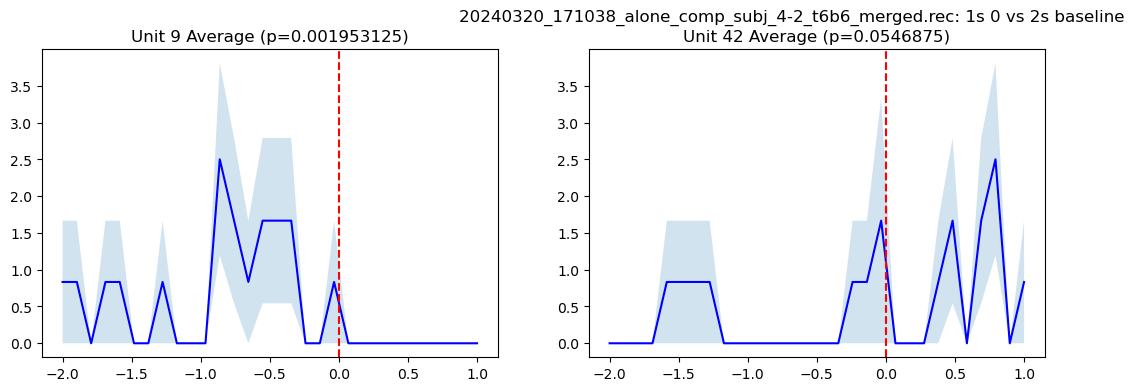

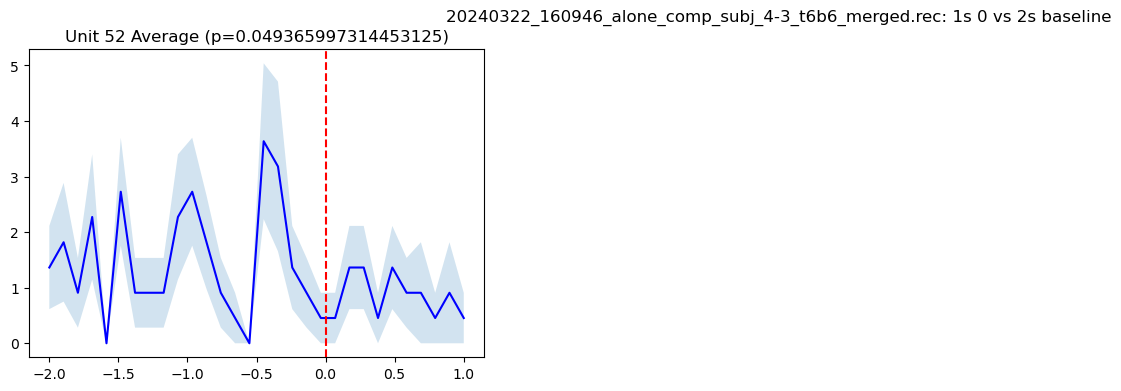

<Figure size 2000x0 with 0 Axes>

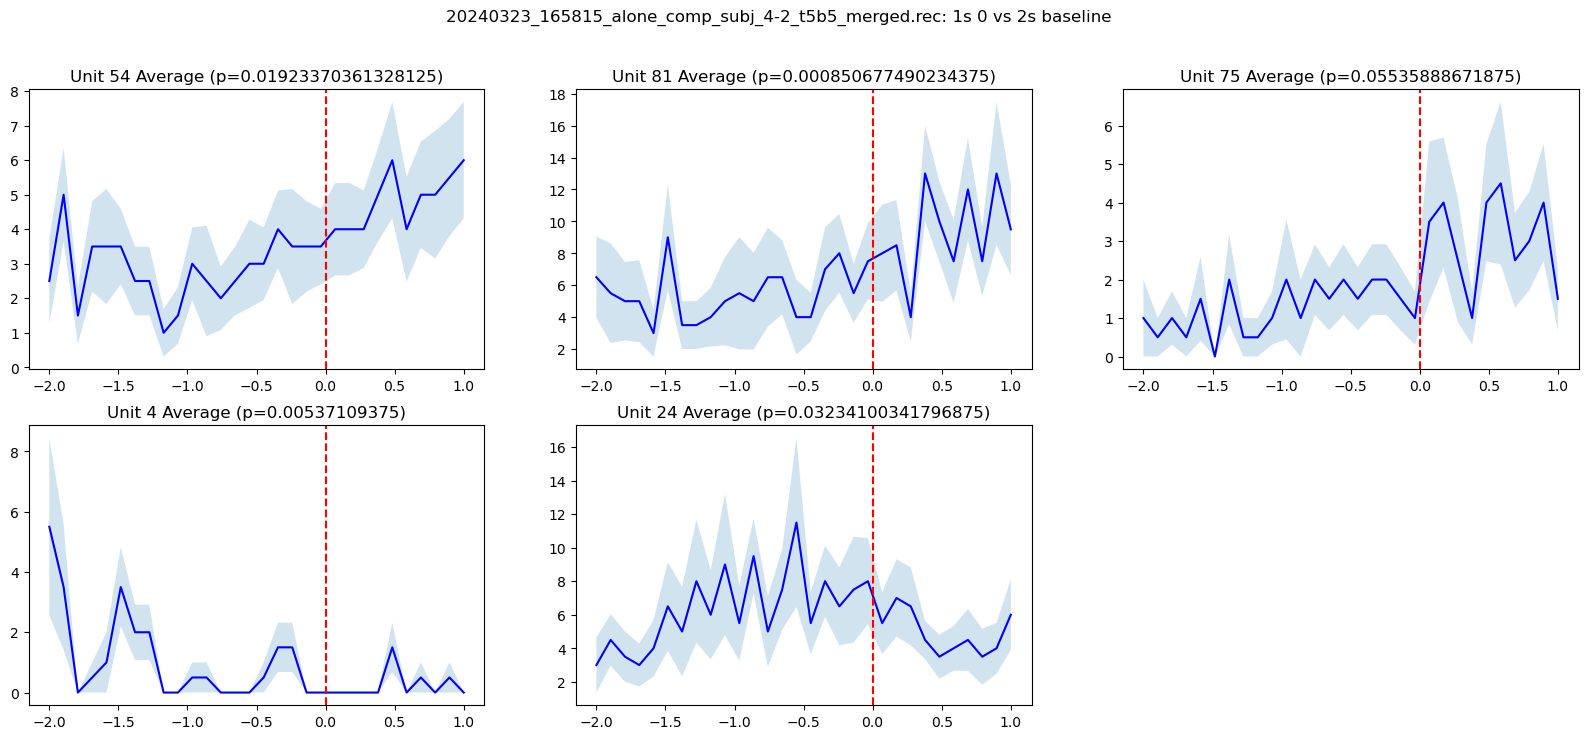

In [5]:
clust1_df = spike_analysis.wilcox_baseline_v_event_collection('0', 1, 2)

<Figure size 2000x0 with 0 Axes>

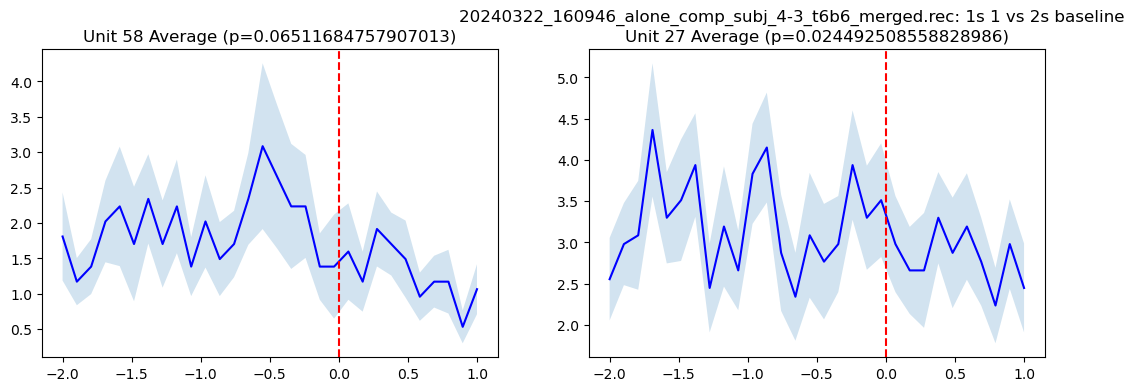

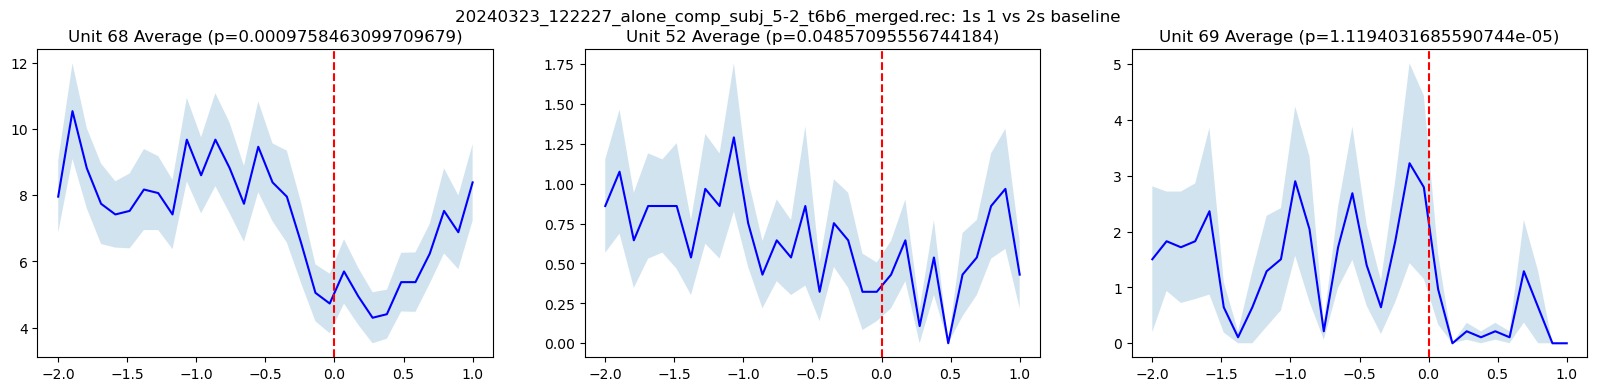

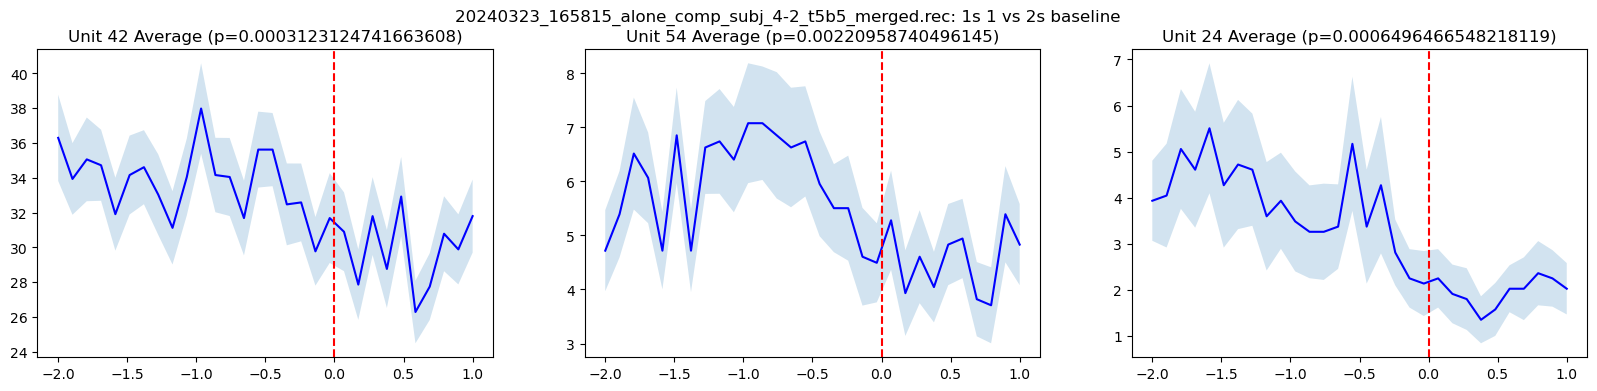

In [6]:
clust1_df = spike_analysis.wilcox_baseline_v_event_collection('1', 1, 2)

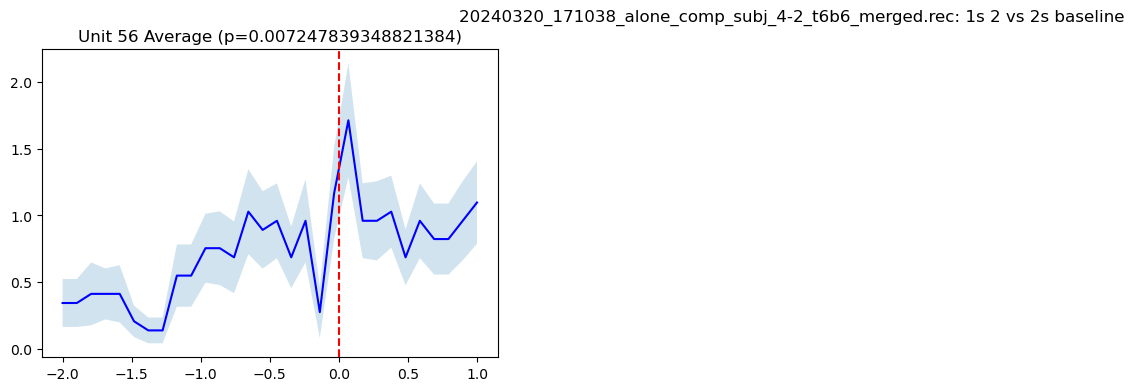

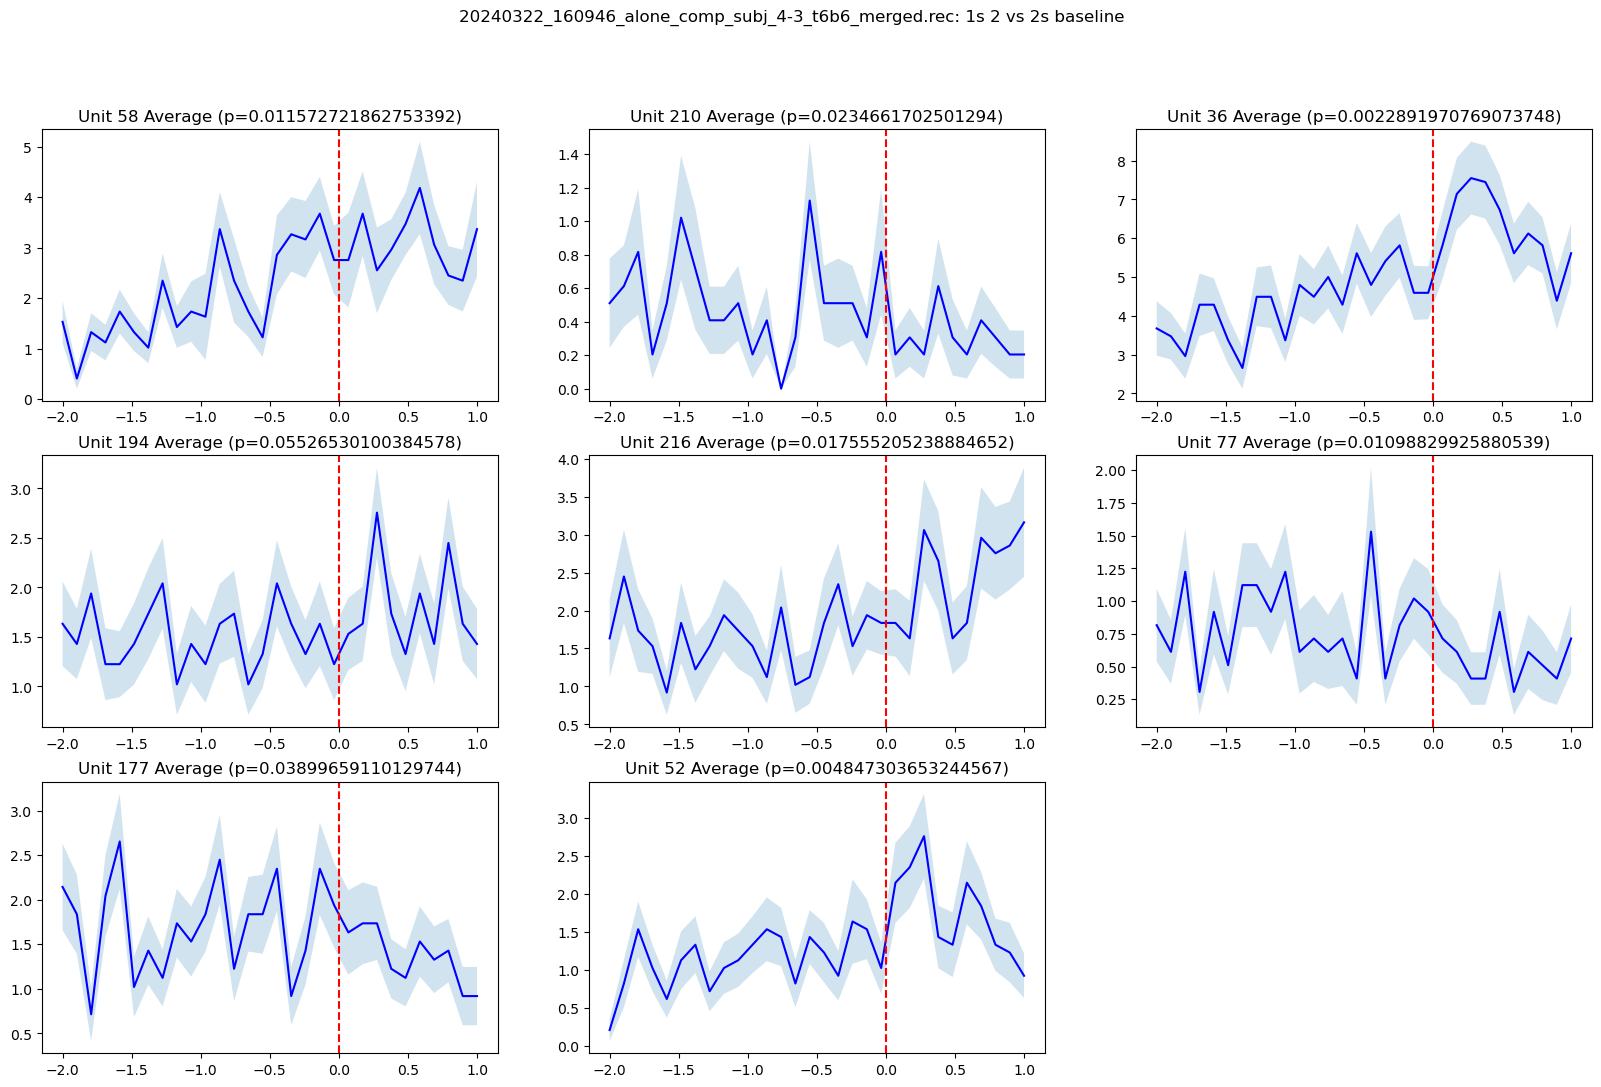

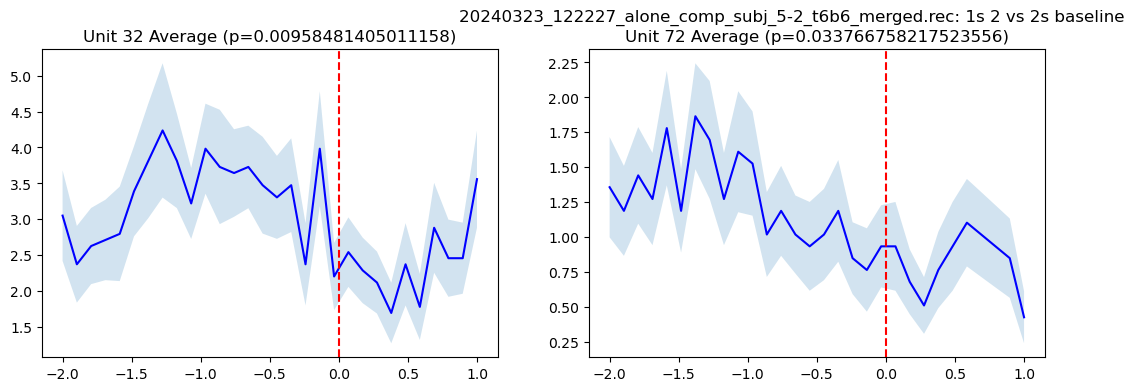

<Figure size 2000x0 with 0 Axes>

In [7]:
clust1_df = spike_analysis.wilcox_baseline_v_event_collection('2', 1, 2)

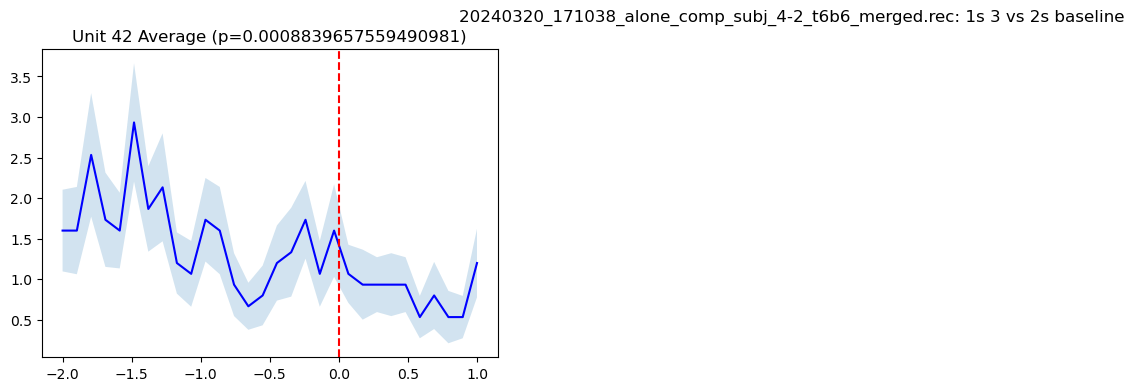

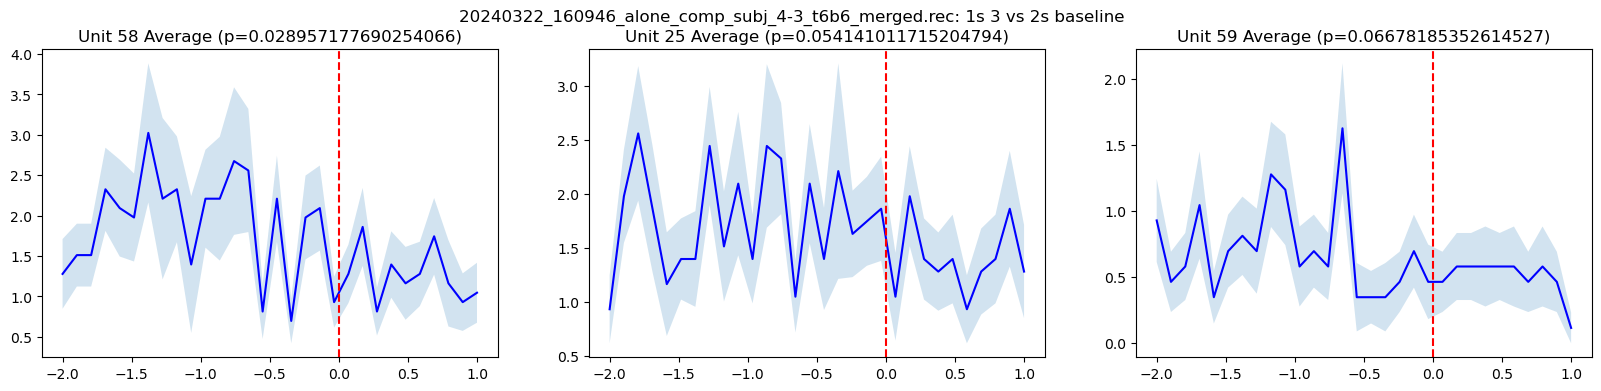

<Figure size 2000x0 with 0 Axes>

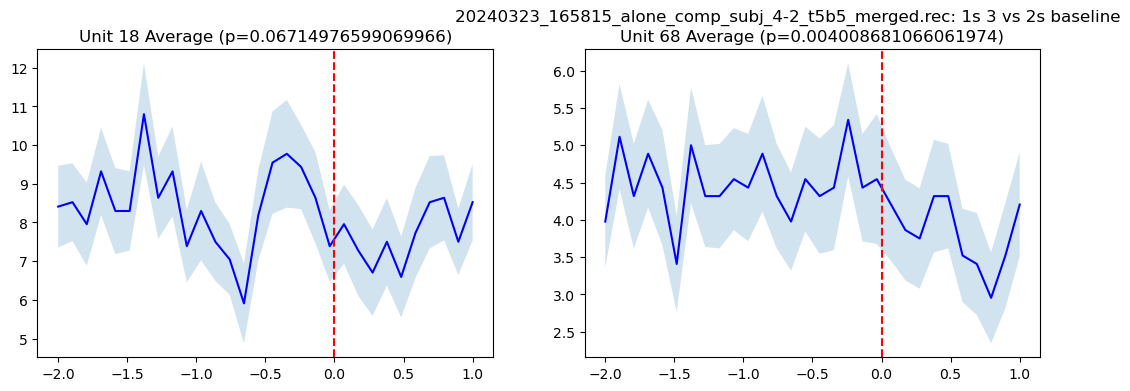

In [8]:
clust1_df = spike_analysis.wilcox_baseline_v_event_collection('3', 1, 2)

## Keeping `timebin = 100` but adding `smoothing_window = 300`

In [9]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window = 300, ignore_freq = 0.5)

All set to analyze


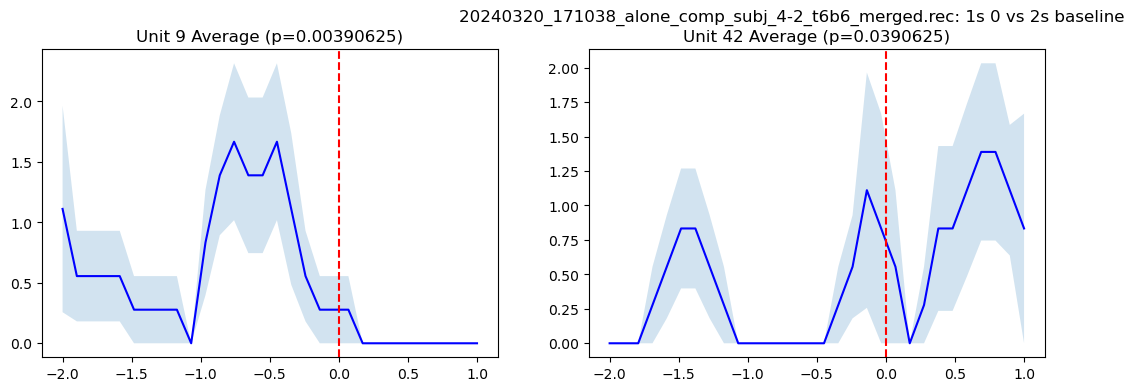

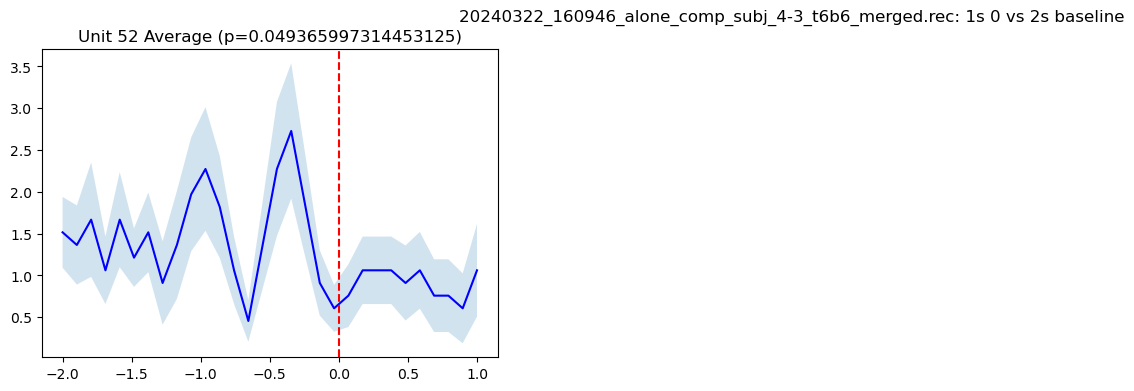

<Figure size 2000x0 with 0 Axes>

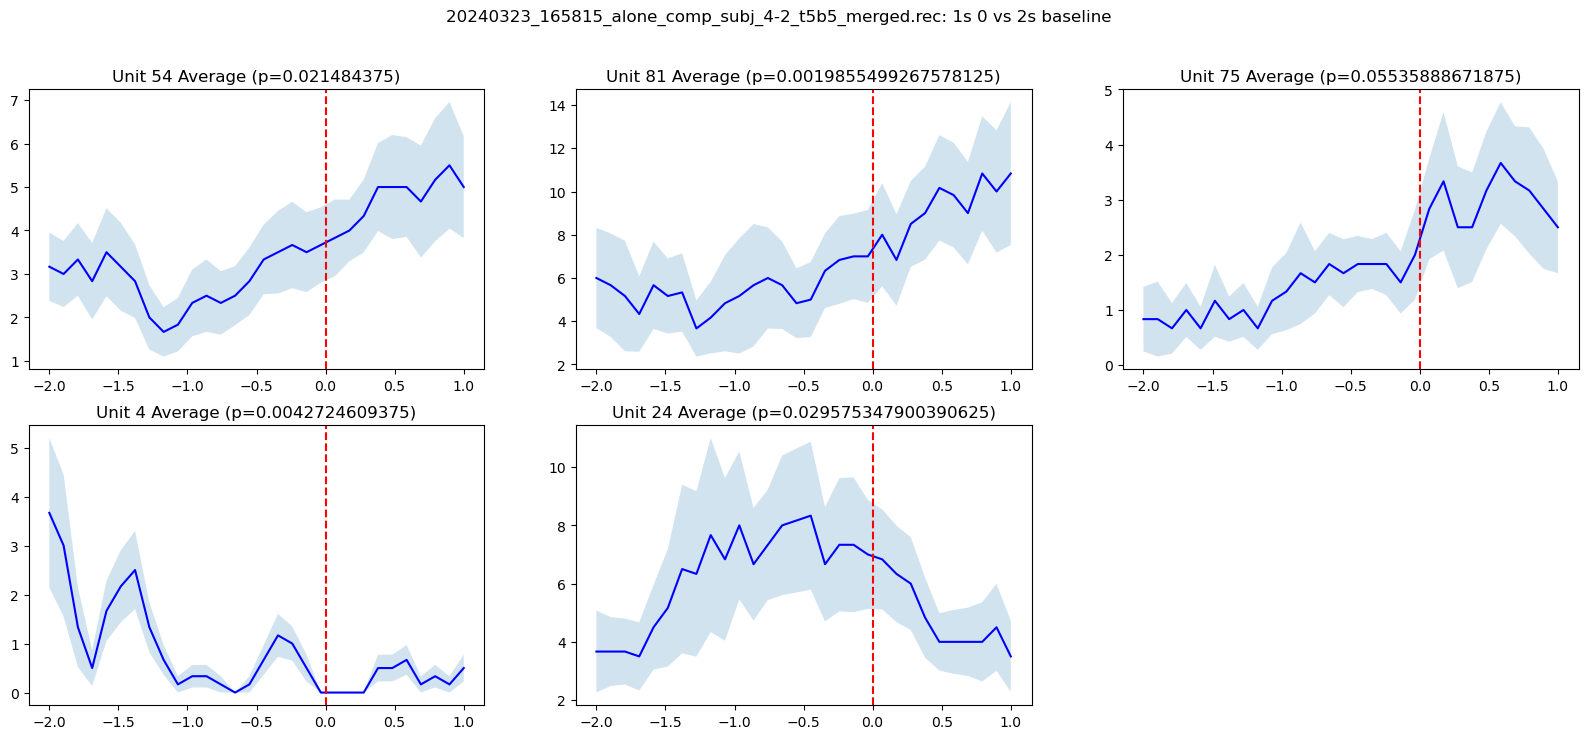

In [10]:
clust0_df = spike_analysis.wilcox_baseline_v_event_collection('0', 1, 2)

<Figure size 2000x0 with 0 Axes>

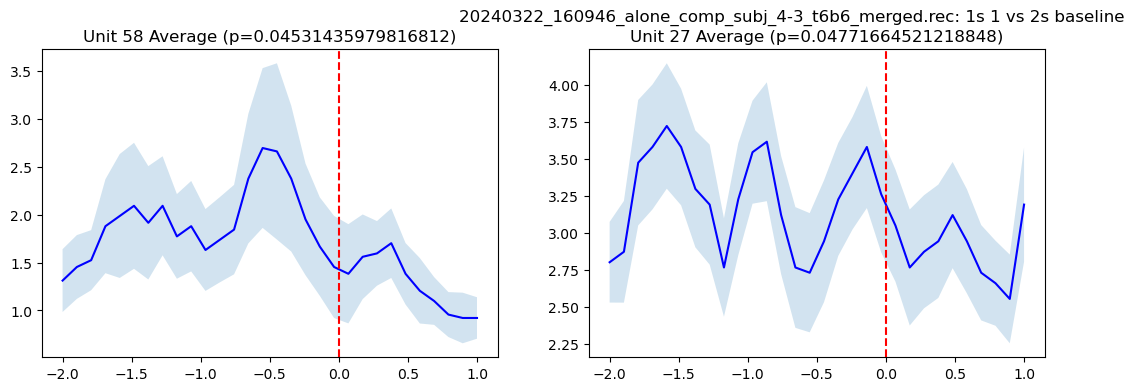

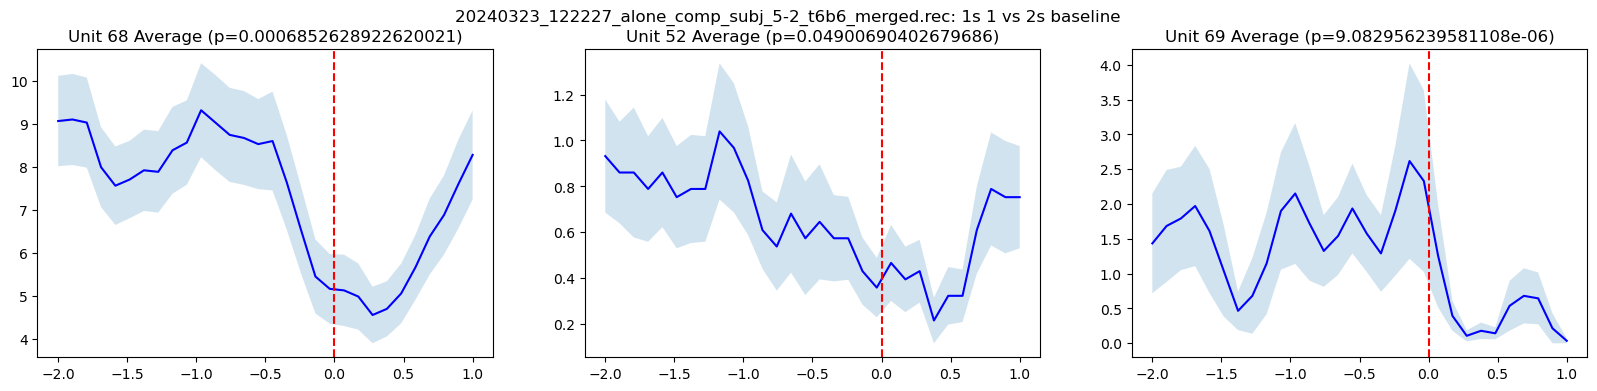

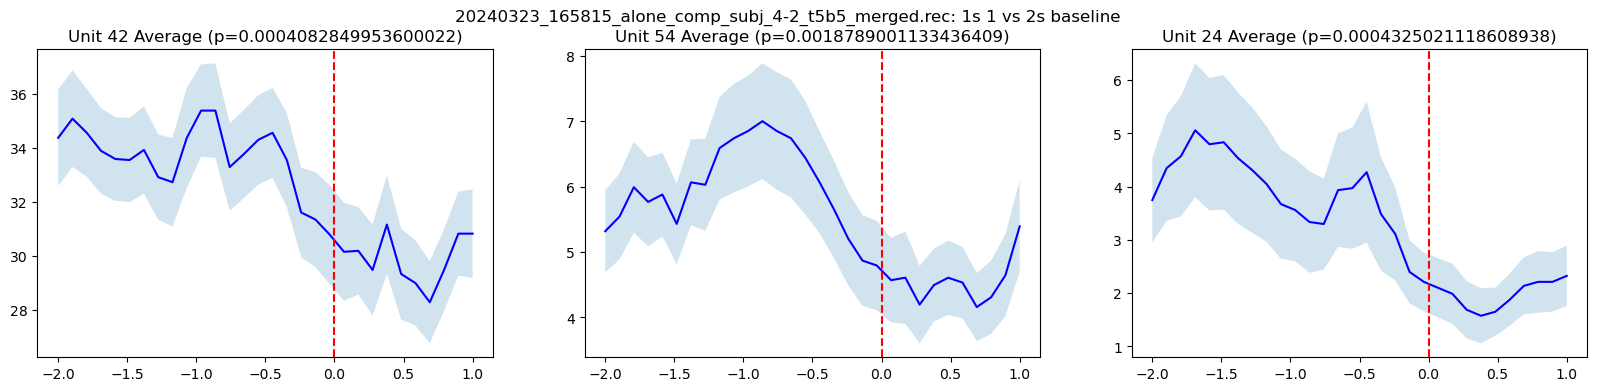

In [11]:
clust1_df = spike_analysis.wilcox_baseline_v_event_collection('1', 1, 2)

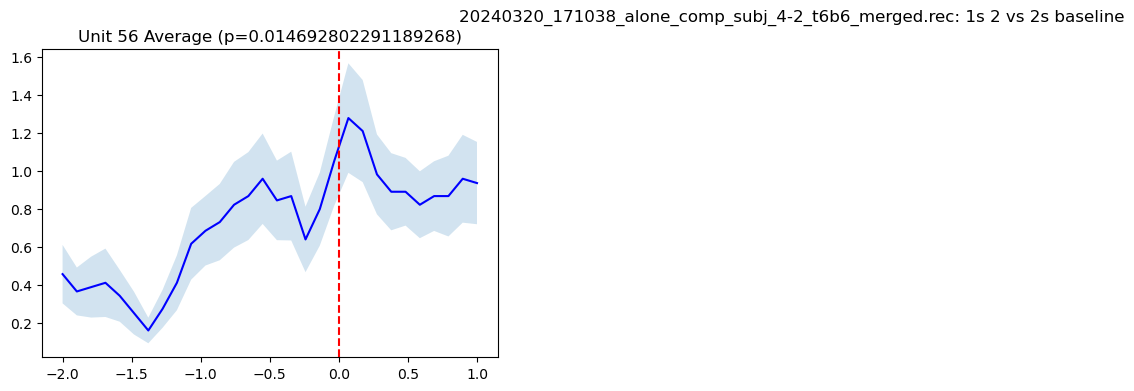

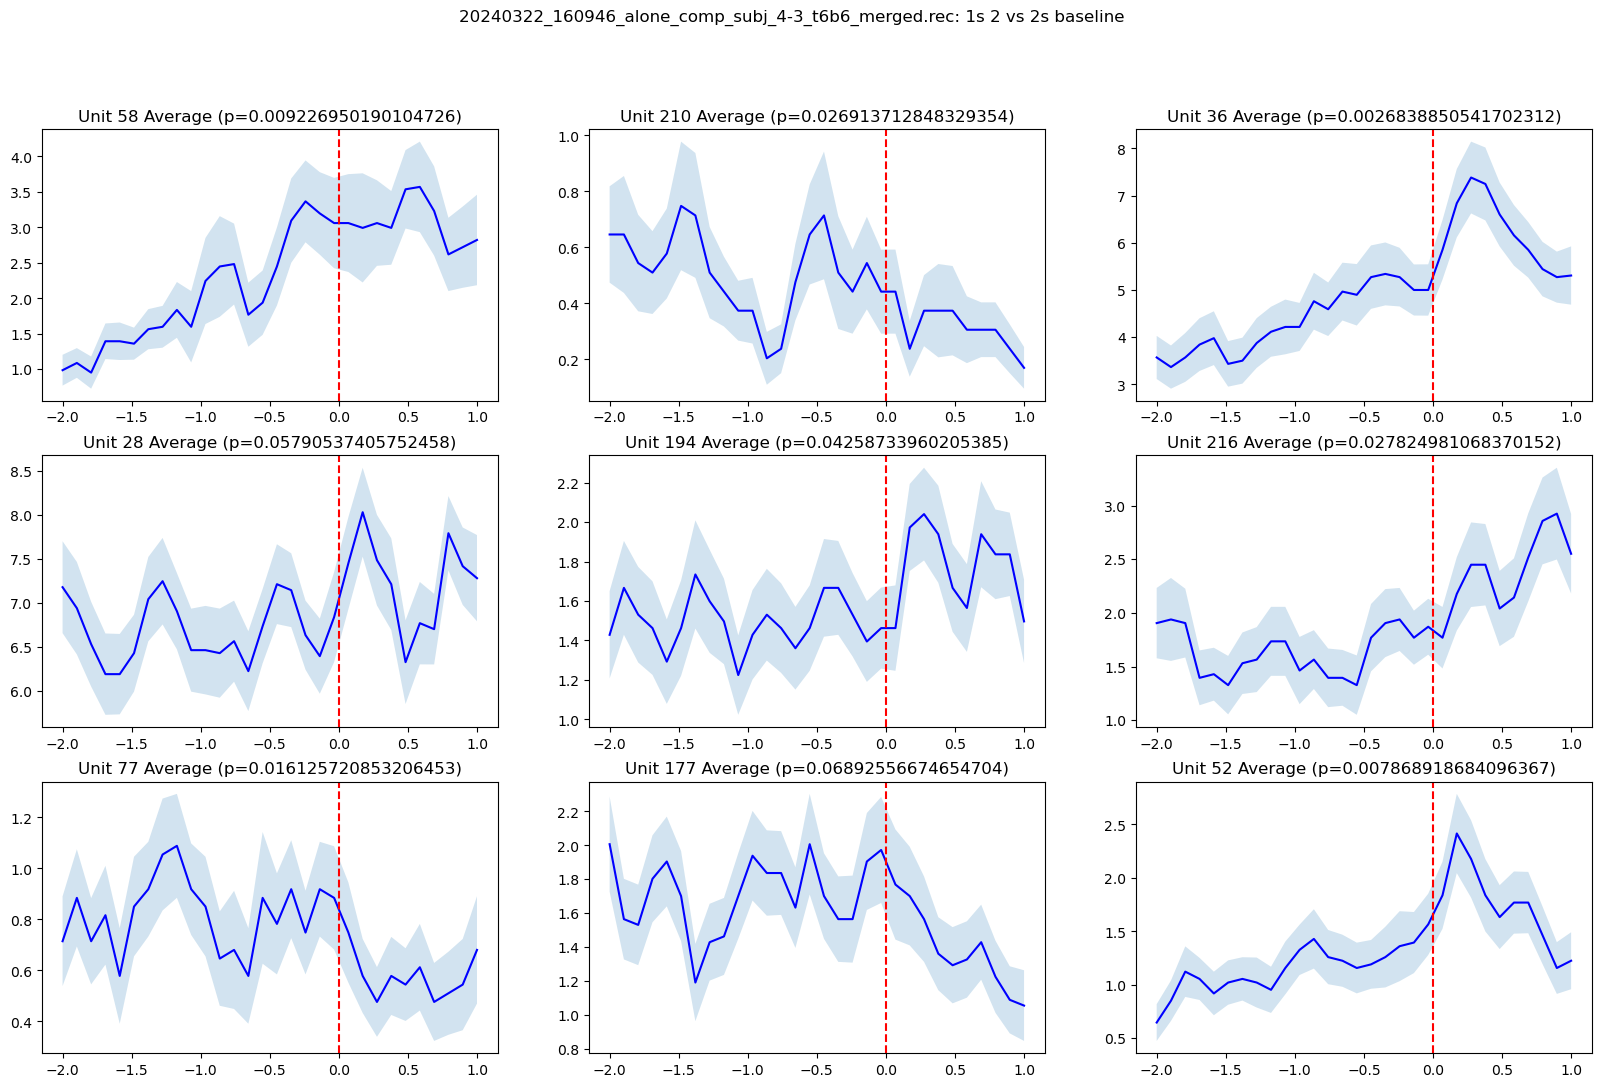

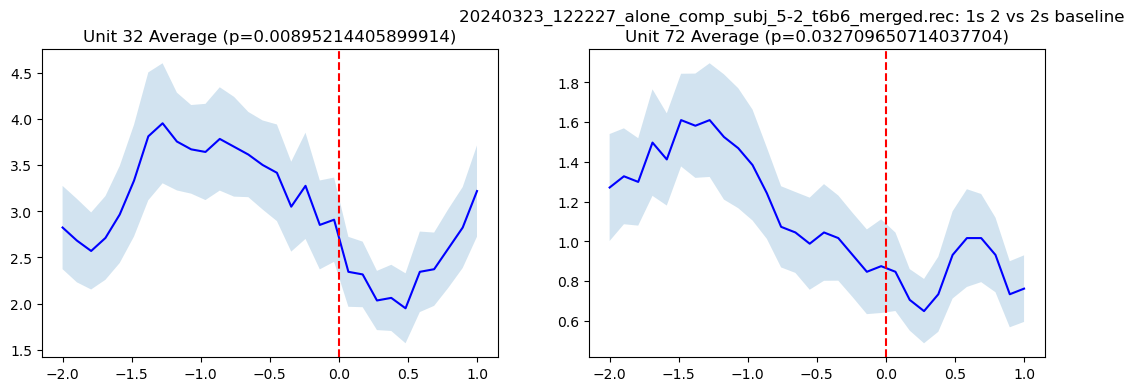

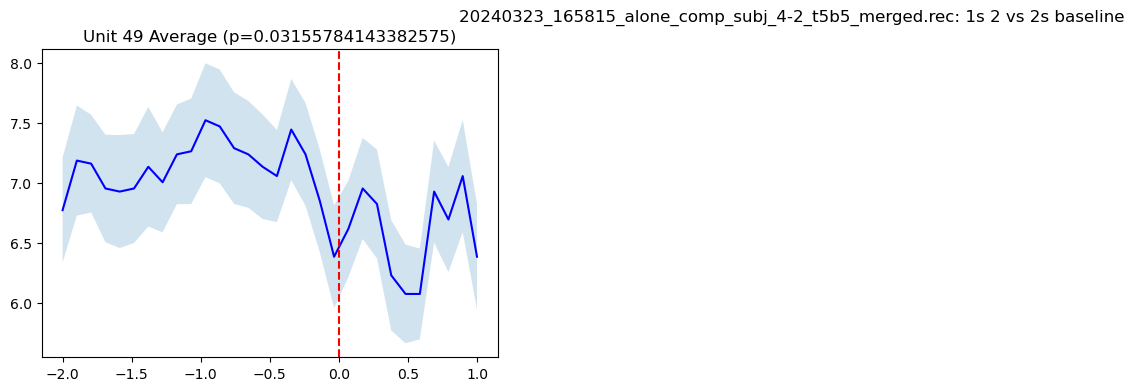

In [12]:
clust2_df = spike_analysis.wilcox_baseline_v_event_collection('2', 1, 2)

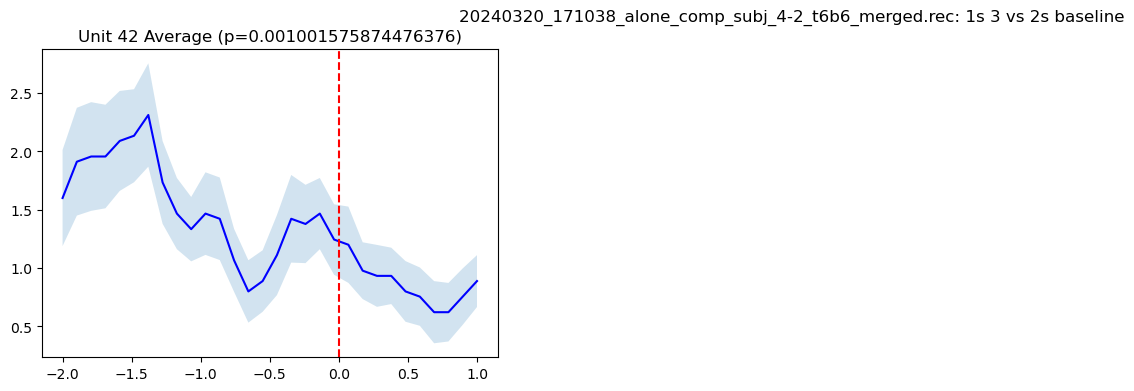

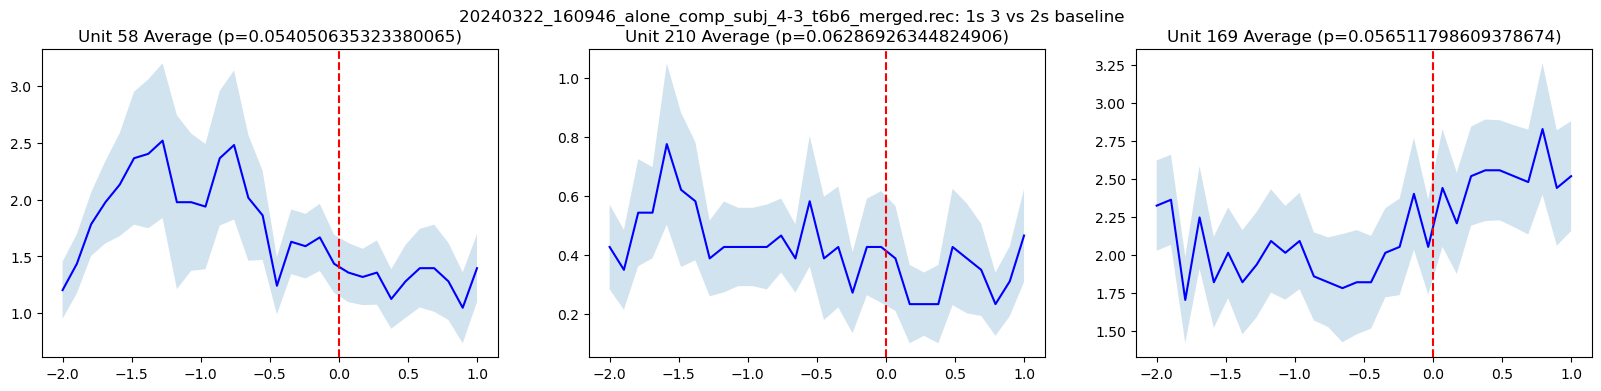

<Figure size 2000x0 with 0 Axes>

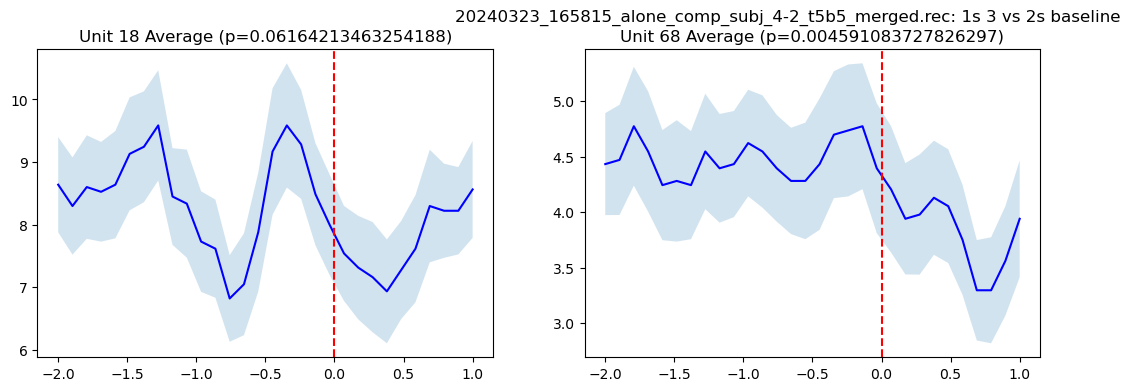

In [13]:
clust3_df = spike_analysis.wilcox_baseline_v_event_collection('3', 1, 2)

In [14]:
# Define the clusters we are interested in
clusters_of_interest = ['0', '1', '2', '3', '5', '6', '7']

# Initialize a dictionary to store total lengths and count of ranges for each cluster
cluster_lengths = {cluster: [] for cluster in clusters_of_interest}

# Iterate through all keys in timestamp_dicts
for recording_key in timestamp_dicts.keys():
    recording = timestamp_dicts[recording_key]
    # Iterate through each cluster of interest
    for cluster in clusters_of_interest:
        # Check if the current cluster exists in the recording
        if cluster in recording:
            # Compute the length of each range in the cluster
            lengths = [end - start for start, end in recording[cluster]]
            # Extend the list for this cluster with the new lengths
            cluster_lengths[cluster].extend(lengths)

# Compute the average length for each cluster
average_lengths = {}
for cluster, lengths in cluster_lengths.items():
    if lengths:  # Ensure there are lengths to calculate an average
        average_lengths[cluster] = np.mean(lengths)
    else:
        average_lengths[cluster] = None  # No data for this cluster

# Print the average lengths for each cluster
for cluster, avg_length in average_lengths.items():
    print(f"Average length for cluster {cluster}: {avg_length:.2f} ms")

Average length for cluster 0: 909.45 ms
Average length for cluster 1: 1265.00 ms
Average length for cluster 2: 652.32 ms
Average length for cluster 3: 1355.66 ms
Average length for cluster 5: 806.84 ms
Average length for cluster 6: 1056.55 ms
Average length for cluster 7: 728.58 ms


In [15]:
# Define the clusters we are interested in
clusters_of_interest = ['0', '1', '2', '3', '5', '6', '7']

# Initialize a dictionary to store lengths of ranges for each cluster
cluster_lengths = {cluster: [] for cluster in clusters_of_interest}

# Iterate through all keys in timestamp_dicts
for recording_key in timestamp_dicts.keys():
    recording = timestamp_dicts[recording_key]
    # Gather lengths from each cluster in the recording
    for cluster, ranges in recording.items():
        if cluster in clusters_of_interest:
            # Calculate the length of each range in the cluster
            lengths = [end - start for start, end in ranges]
            # Extend the list for this cluster with these lengths
            cluster_lengths[cluster].extend(lengths)

# Compute the median length for each cluster
median_lengths = {}
for cluster, lengths in cluster_lengths.items():
    if lengths:  # Ensure there are lengths to calculate a median
        median_lengths[cluster] = np.median(lengths)
    else:
        median_lengths[cluster] = None  # No data for this cluster

# Print the median lengths for each cluster
for cluster, median_length in median_lengths.items():
    print(f"Median length for cluster {cluster}: {median_length} ms")

Median length for cluster 0: 555.0 ms
Median length for cluster 1: 901.0 ms
Median length for cluster 2: 415.0 ms
Median length for cluster 3: 831.0 ms
Median length for cluster 5: 693.0 ms
Median length for cluster 6: 554.0 ms
Median length for cluster 7: 485.0 ms


In [16]:
# Initialize a dictionary to store total lengths for each recording
recording_total_lengths = {}

# Iterate through all keys in timestamp_dicts
for recording_key in timestamp_dicts.keys():
    recording = timestamp_dicts[recording_key]
    # Initialize a total length variable for this recording
    total_length = 0

    # Sum lengths from each cluster in the recording
    for cluster, ranges in recording.items():
        # Calculate the length of each range in the cluster and sum them
        total_length += sum(end - start for start, end in ranges)

    # Store the total length in the dictionary under the recording key
    recording_total_lengths[recording_key] = total_length

# Print the total lengths for each recording formatted to two decimal places
for recording_key, total_length in recording_total_lengths.items():
    minutes = total_length / 1000 / 60  # Convert to minutes
    print(f"Total combined length for {recording_key}: {minutes:.2f} min")

Total combined length for 20240320_171038_alone_comp_subj_4-2: 9.48 min
Total combined length for 20240322_120625_alone_comp_subj_3-3: 9.12 min
Total combined length for 20240322_160946_alone_comp_subj_4-3: 9.48 min
Total combined length for 20240323_122227_alone_comp_subj_5-2: 9.21 min
Total combined length for 20240323_144517_alone_comp_subj_3-1: 9.71 min
Total combined length for 20240323_165815_alone_comp_subj_4-2: 8.35 min


In [17]:
rce3_alone_clusters

video_name current_subject  \
0   20240320_171038_alone_comp_subj_4-2_and_4-3.1             4.2   
1   20240320_171038_alone_comp_subj_4-2_and_4-3.1             4.3   
2   20240322_120625_alone_comp_subj_3-3_and_3-4.1             3.3   
3   20240322_120625_alone_comp_subj_3-3_and_3-4.1             3.4   
4   20240322_160946_alone_comp_subj_4-3_and_4-4.1             4.3   
5   20240322_160946_alone_comp_subj_4-3_and_4-4.1             4.4   
6   20240323_122227_alone_comp_subj_5-2_and_5-3.1             5.2   
7   20240323_122227_alone_comp_subj_5-2_and_5-3.1             5.3   
8   20240323_144517_alone_comp_subj_3-1_and_3-4.1             3.1   
9   20240323_144517_alone_comp_subj_3-1_and_3-4.1             3.4   
10  20240323_165815_alone_comp_subj_4-2_and_4-4.1             4.2   
11  20240323_165815_alone_comp_subj_4-2_and_4-4.1             4.4   

                            cluster_index_ranges_dict  \
0   {7: [(0, 13), (587, 590), (434, 442), (449, 47...   
1   {7: [(0, 13), (587, 590), (434, 442), (449, 47...   
2   {3: [(66, 105), (242, 267), (412, 418), (174, ...   
3   {3: [(66, 105), (242, 267), (412, 418), (174, ...   
4   {7: [(0, 9), (13, 33), (91, 97), (389, 402), (...   
5   {7: [(0, 9), (13, 33), (91, 97), (389, 402), (...   
6   {7: [(0, 6), (236, 242), (438, 459), (545, 572...   
7   {7: [(0, 6), (236, 242), (438, 459), (545, 572...   
8   {5: [(0, 8), (25, 40), (55, 67), (133, 157), (...   
9   {5: [(0, 8), (25, 40), (55, 67), (133, 157), (...   
10  {5: [(0, 24), (40, 62), (112, 158), (186, 203)...   
11  {5: [(0, 24), (40, 62), (112, 158), (186, 203)...   

                            cluster_times_ranges_dict  \
0   {7: [(1600609, 1601302), (1630059, 1630198), (...   
1   {7: [(1600609, 1601302), (1630059, 1630198), (...   
2   {3: [(1527574, 1529514), (1536374, 1537622), (...   
3   {3: [(1527574, 1529514), (1536374, 1537622), (...   
4   {7: [(1438255, 1438740), (1438878, 1439918), (...   
5   {7: [(1438255, 1438740), (1438878, 1439918), (...   
6   {7: [(1600609, 1600887), (1612389, 1612667), (...   
7   {7: [(1600609, 1600887), (1612389, 1612667), (...   
8   {5: [(1683207, 1683623), (1684455, 1685217), (...   
9   {5: [(1683207, 1683623), (1684455, 1685217), (...   
10  {5: [(1698937, 1699907), (1700531, 1701431), (...   
11  {5: [(1698937, 1699907), (1700531, 1701431), (...   

                       cluster_timestamps_ranges_dict  \
0   {7: [(34079916, 34093775), (34668911, 34671683...   
1   {7: [(34079916, 34093775), (34668911, 34671683...   
2   {3: [(34169998, 34208802), (34346003, 34370949...   
3   {3: [(34169998, 34208802), (34346003, 34370949...   
4   {7: [(34096547, 34106248), (34109019, 34129808...   
5   {7: [(34096547, 34106248), (34109019, 34129808...   
6   {7: [(34070215, 34075759), (34305813, 34311357...   
7   {7: [(34070215, 34075759), (34305813, 34311357...   
8   {5: [(34957172, 34965487), (34982117, 34997362...   
9   {5: [(34957172, 34965487), (34982117, 34997362...   
10  {5: [(36182281, 36201683), (36214156, 36232172...   
11  {5: [(36182281, 36201683), (36214156, 36232172...   

                 trial_cluster_timestamps_ranges_dict  \
0   {'lose_7': [(34079916, 34093775), (34668911, 3...   
1   {'win_7': [(34079916, 34093775), (34668911, 34...   
2   {'tie_3': [(34169998, 34208802), (34346003, 34...   
3   {'tie_3': [(34169998, 34208802), (34346003, 34...   
4   {'tie_7': [(34096547, 34106248), (34109019, 34...   
5   {'tie_7': [(34096547, 34106248), (34109019, 34...   
6   {'lose_7': [(34070215, 34075759), (34305813, 3...   
7   {'win_7': [(34070215, 34075759), (34305813, 34...   
8   {'lose_5': [(34957172, 34965487), (34982117, 3...   
9   {'win_5': [(34957172, 34965487), (34982117, 34...   
10  {'win_5': [(36182281, 36201683), (36214156, 36...   
11  {'lose_5': [(36182281, 36201683), (36214156, 3...   

                      trial_cluster_times_ranges_dict  \
0   {'lose_7': [(1600609, 1601302), (1630059, 1630...   
1   {'win_7': [(1600609, 1601302), (1630059, 16301...   
2 

In [18]:
rec1 = timestamp_dicts['20240320_171038_alone_comp_subj_4-2']

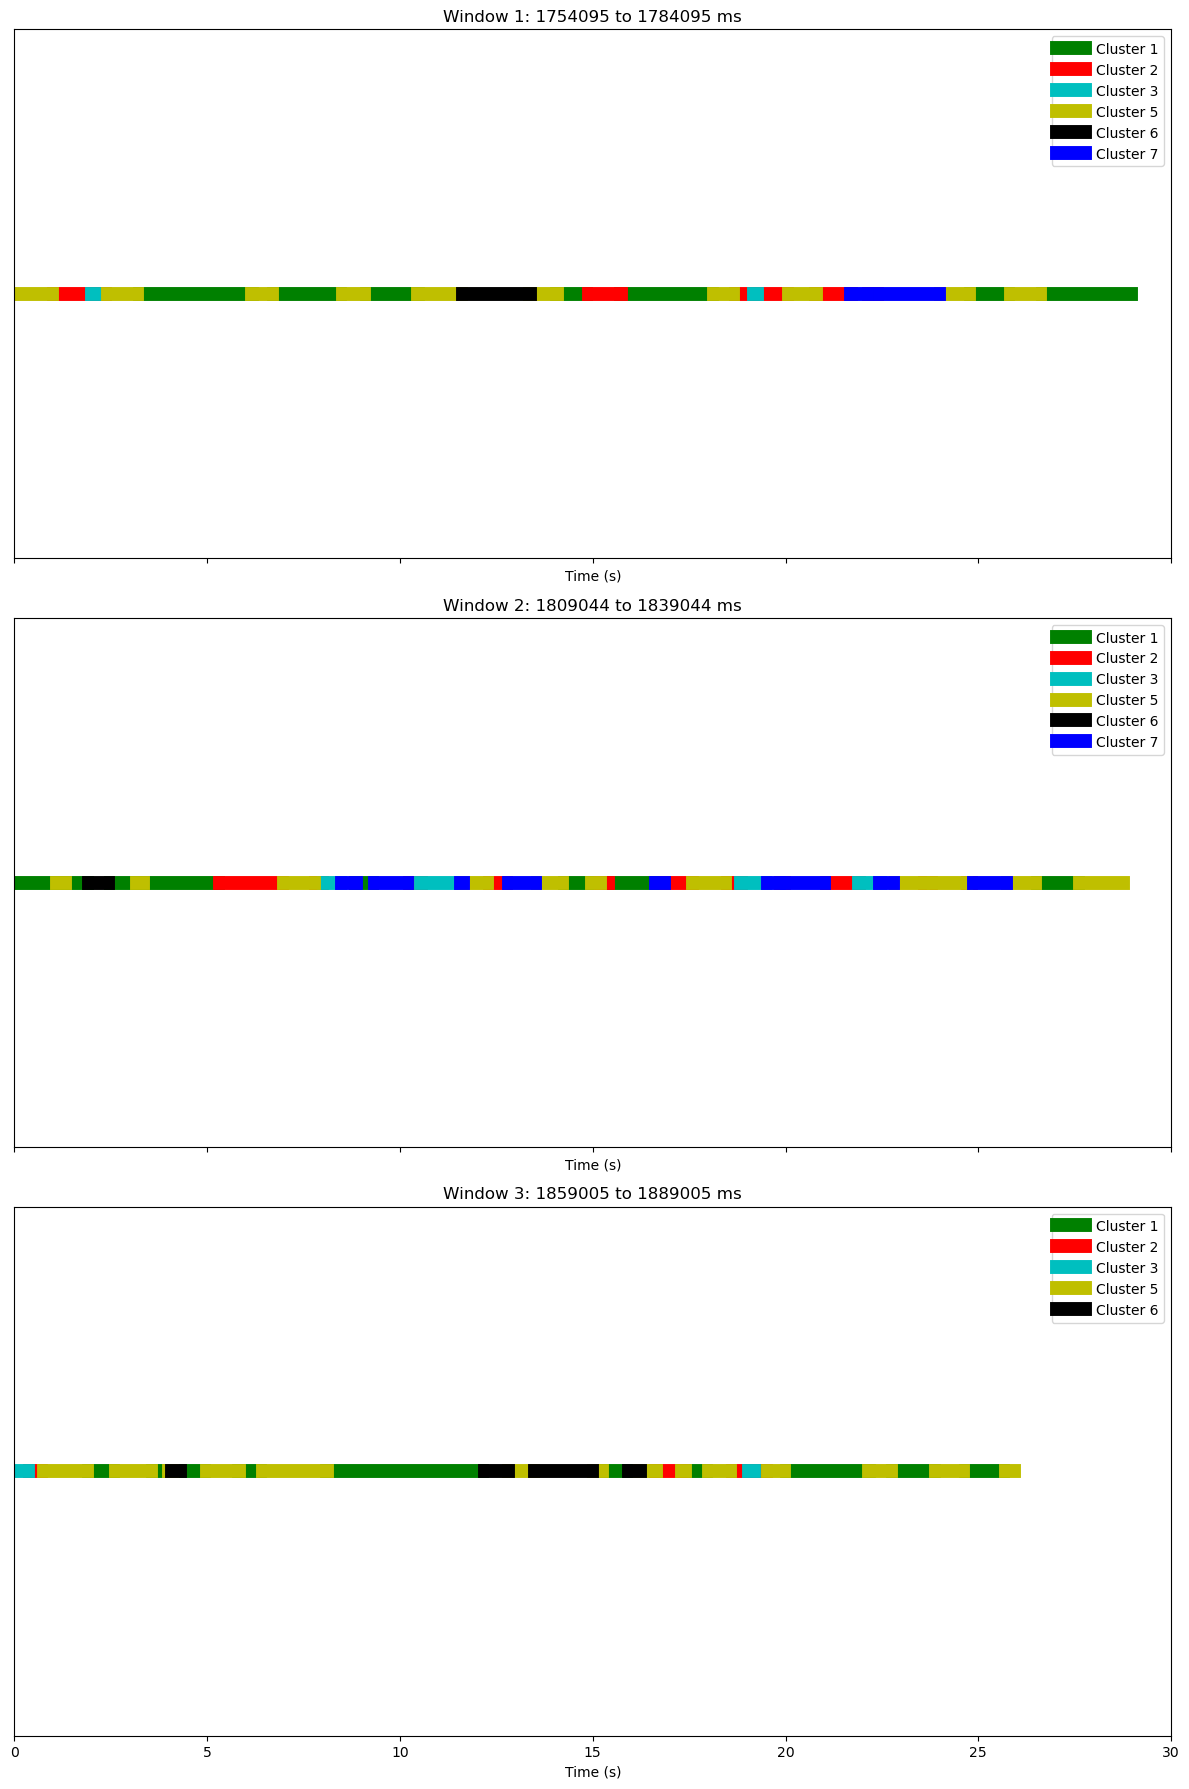

[(np.int64(1754095), np.int64(1784095)),
 (np.int64(1809044), np.int64(1839044)),
 (np.int64(1859005), np.int64(1889005))]

In [19]:
# Finding the lowest timestamp
min_timestamp = min(min(ranges[:, 0]) for ranges in rec1.values())

# Function to find the next starting point for the window
def find_next_start(current_start, all_timestamps, gap):
    # Find the first timestamp after the current start + gap
    for timestamp in sorted(all_timestamps):
        if timestamp > current_start + gap:
            return timestamp
    return None  # Return None if no valid start is found

# Gather all start timestamps from the clusters
all_starts = np.concatenate([ranges[:, 0] for ranges in rec1.values()])

# Find the starting points for three dynamic windows
dynamic_windows = []
current_start = min_timestamp
for _ in range(3):
    next_start = find_next_start(current_start, all_starts, 30100)
    if next_start:
        dynamic_windows.append((next_start, next_start + 30000))
        current_start = next_start

# Prepare to replot with an updated legend order and handling cases where no data fits a window
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Colors for different cluster ids
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Dictionary to manage colors consistently across clusters
cluster_colors = {str(i): colors[i % len(colors)] for i in range(1, 8)}

# Conversion factor from milliseconds to seconds
ms_to_s = 1000

for window_num, (window_start, window_end) in enumerate(dynamic_windows):
    ax = axes[window_num]
    data_present = False  # Flag to check if any data is plotted

    for key in sorted(rec1, key=int):  # Sort keys to ensure order in the legend
        ranges = rec1[key]
        for start, end in ranges:
            if start < window_end and end > window_start:
                plot_start = (max(start, window_start) - window_start) / ms_to_s
                plot_end = (min(end, window_end) - window_start) / ms_to_s
                ax.plot([plot_start, plot_end], [0, 0], marker='|', color=cluster_colors[key], 
                        linewidth=10, label=f"Cluster {key}")
                data_present = True

    # Setting x-axis in seconds and formatting
    ax.set_xlim(0, 30)
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Window {window_num+1}: {window_start} to {window_end} ms")
    ax.axes.yaxis.set_visible(False)

    # Only show legend if data was present
    if data_present:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # Remove duplicates
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()

# Return the dynamic window definitions for verification
dynamic_windows

In [20]:
# Initialize the dictionary
timestamp_dicts2 = {}

# Loop through each row of the DataFrame to populate the dictionary
for index, row in rce3_alone_clusters.iterrows():
    # Define the key as a combination of session_dir and current_subject
    key = f"{row['session_dir']}"

    start_pos = key.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    key_without_suffix = key[:end_pos]
    
    # Initialize nested dictionary for this key if not already present
    if key not in timestamp_dicts2:
        timestamp_dicts2[key_without_suffix] = {}

    # Loop through the cluster_timestamps_ranges_dict to populate conditions
    for condition, ranges in row['trial_cluster_timestamps_ranges_dict'].items():
        # Check if the condition key already exists, if not initialize a list
        if condition not in timestamp_dicts2[key_without_suffix]:
            timestamp_dicts2[key_without_suffix][str(condition)] = []

        # Extend the existing list with new ranges
        modified_ranges = [(start // 20, end // 20) for start, end in ranges]
        timestamp_dicts2[key_without_suffix][str(condition)].extend(modified_ranges)

In [21]:
rec1_ex = timestamp_dicts2['20240320_171038_alone_comp_subj_4-2']

In [22]:
rec1_ex.keys()

dict_keys(['win_7', 'win_1', 'win_5', 'win_2', 'win_3', 'win_6', 'win_0', 'tie_5', 'tie_1', 'tie_7', 'tie_3', 'tie_2', 'tie_0'])

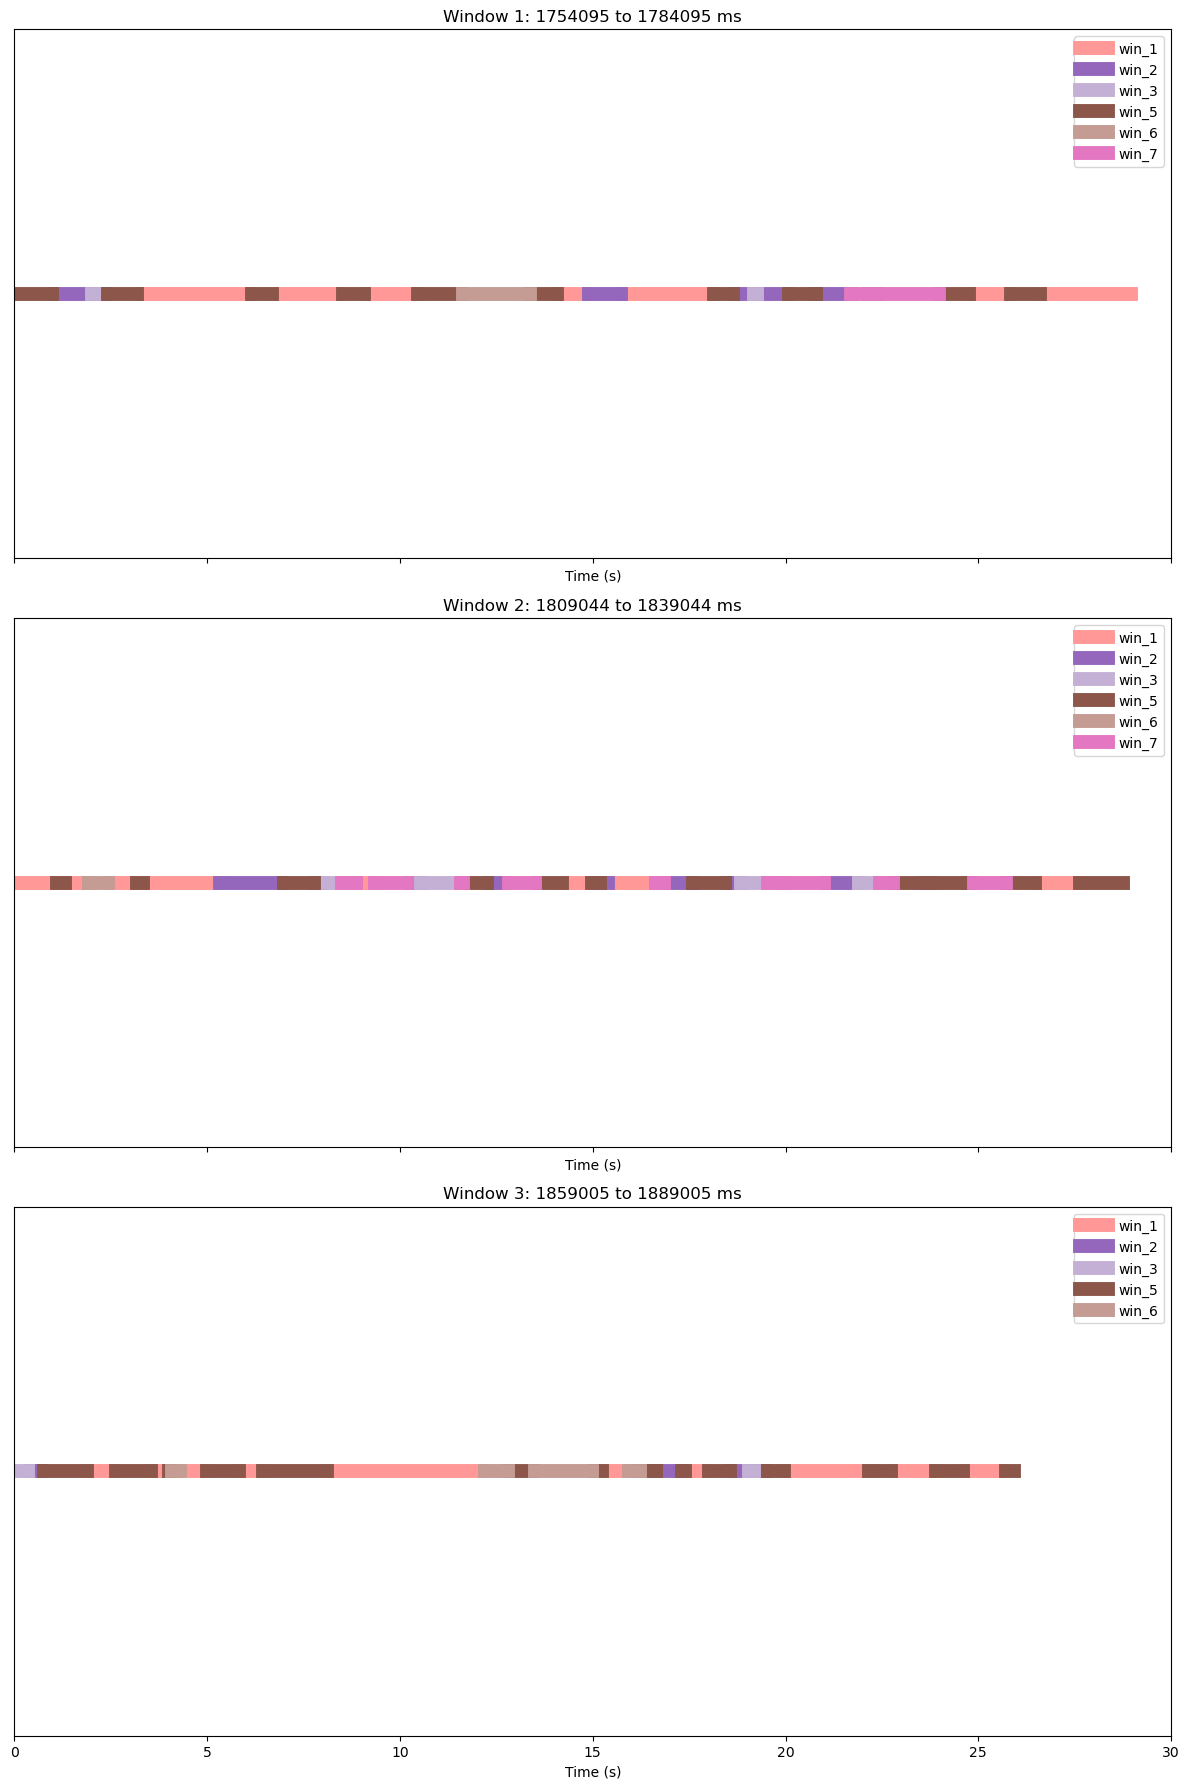

In [23]:
# Gather all unique keys from rec1_ex
all_keys = sorted(rec1_ex.keys())

# Generate colors for each unique key
cluster_colors = {key: plt.cm.tab20(i % 20) for i, key in enumerate(all_keys)}


# Function to find the next starting point for the window based on the first timestamp found after a gap
def find_next_start(current_start, all_timestamps, gap):
    # Find the first timestamp after the current start + gap
    for timestamp in sorted(all_timestamps):
        if timestamp > current_start + gap:
            return timestamp
    return None  # Return None if no valid start is found

# Gather all start timestamps from the categories
all_starts = np.concatenate([np.array(ranges)[:, 0] for ranges in rec1_ex.values()])

# Calculate dynamic windows based on the lowest timestamp and a 30,100 ms gap
dynamic_windows = []
current_start = min(all_starts)
for _ in range(3):
    next_start = find_next_start(current_start, all_starts, 30100)
    if next_start:
        dynamic_windows.append((next_start, next_start + 30000))
        current_start = next_start

# Replot with dynamic windows
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

for window_num, (window_start, window_end) in enumerate(dynamic_windows):
    ax = axes[window_num]
    data_present = False  # Flag to check if any data is plotted

    for key in all_keys:  # Ensure you use the sorted list from earlier
        ranges = np.array(rec1_ex[key], dtype=int)
        for start, end in ranges:
            if start < window_end and end > window_start:
                plot_start = (max(start, window_start) - window_start) / 1000  # Adjusting for milliseconds to seconds
                plot_end = (min(end, window_end) - window_start) / 1000
                ax.plot([plot_start, plot_end], [0, 0], marker='|', color=cluster_colors[key], 
                        linewidth=10, label=f"{key}")
                data_present = True

    # Setting x-axis in seconds and formatting
    ax.set_xlim(0, 30)
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Window {window_num+1}: {window_start} to {window_end} ms")
    ax.axes.yaxis.set_visible(False)

    # Only show legend if data was present
    if data_present:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # Remove duplicates
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()

In [24]:
timestamp_dicts2.keys()

dict_keys(['20240320_171038_alone_comp_subj_4-2', '20240322_120625_alone_comp_subj_3-3', '20240322_160946_alone_comp_subj_4-3', '20240323_122227_alone_comp_subj_5-2', '20240323_144517_alone_comp_subj_3-1', '20240323_165815_alone_comp_subj_4-2'])

In [25]:
rec2_ex = timestamp_dicts2['20240323_122227_alone_comp_subj_5-2']

In [26]:
rec3_ex = timestamp_dicts2['20240323_144517_alone_comp_subj_3-1']

In [27]:
rec4_ex = timestamp_dicts2['20240323_165815_alone_comp_subj_4-2']

## Combine short-gap clusters and remove short-length clusters (250 ms)

In [28]:
def combine_intervals(ranges):
    """Combine intervals that are within 250 milliseconds of each other."""
    if ranges.size == 0:
        return ranges
    # Sort ranges based on the start times
    sorted_ranges = ranges[ranges[:, 0].argsort()]
    combined = [sorted_ranges[0]]

    for current in sorted_ranges[1:]:
        last = combined[-1]
        # If the current start is within 250 ms of the last end, combine them
        if current[0] - last[1] <= 250:
            combined[-1] = [last[0], max(last[1], current[1])]
        else:
            combined.append(current)

    return np.array(combined)

def remove_short_intervals(ranges):
    """Remove intervals that are less than 250 milliseconds long."""
    return np.array([interval for interval in ranges if interval[1] - interval[0] >= 250])

def process_timestamps_nested(timestamp_dicts):
    timestamp_dicts_cut = {}
    for date_key, clusters in timestamp_dicts.items():
        timestamp_dicts_cut[date_key] = {}
        for cluster_key, intervals in clusters.items():
            if intervals.size > 0:  # Check if there are any intervals
                combined = combine_intervals(intervals)
                cleaned = remove_short_intervals(combined)
                timestamp_dicts_cut[date_key][cluster_key] = cleaned
            else:
                timestamp_dicts_cut[date_key][cluster_key] = np.array([])  # Handle empty input case
    return timestamp_dicts_cut

# Actual usage of functions
timestamp_dicts_cut = process_timestamps_nested(timestamp_dicts)

### Combine short-gap clusters and remove short-length clusters (250 ms) AND print when clipped/combined

In [29]:
def combine_intervals(ranges):
    """Combine intervals that are within 250 milliseconds of each other."""
    if ranges.size == 0:
        return ranges, False
    sorted_ranges = ranges[ranges[:, 0].argsort()]
    combined = [sorted_ranges[0]]
    modified = False

    for current in sorted_ranges[1:]:
        last = combined[-1]
        if current[0] - last[1] <= 250:
            combined[-1] = [last[0], max(last[1], current[1])]
            modified = True  # Set modified to True if any intervals were combined
        else:
            combined.append(current)

    return np.array(combined), modified

def remove_short_intervals(ranges):
    """Remove intervals that are less than 250 milliseconds long."""
    filtered = [interval for interval in ranges if interval[1] - interval[0] >= 250]
    modified = len(filtered) != len(ranges)  # Check if any intervals were removed
    return np.array(filtered), modified

def process_timestamps_nested(timestamp_dicts):
    timestamp_dicts_cut = {}
    for date_key, clusters in timestamp_dicts.items():
        timestamp_dicts_cut[date_key] = {}
        for cluster_key, intervals in clusters.items():
            original_intervals = np.array(intervals)
            if original_intervals.size > 0:
                combined, combined_modified = combine_intervals(original_intervals)
                if combined_modified:
                    print(f"Recording: {date_key}, Cluster: {cluster_key}, Combined intervals due to close proximity.")

                cleaned, cleaned_modified = remove_short_intervals(combined)
                if cleaned_modified:
                    print(f"Recording: {date_key}, Cluster: {cluster_key}, Removed short intervals.")

                timestamp_dicts_cut[date_key][cluster_key] = cleaned
            else:
                timestamp_dicts_cut[date_key][cluster_key] = np.array([])  # Handle empty input case
    return timestamp_dicts_cut

# Actual usage of functions
timestamp_dicts_cut = process_timestamps_nested(timestamp_dicts)

Recording: 20240320_171038_alone_comp_subj_4-2, Cluster: 7, Combined intervals due to close proximity.
Recording: 20240320_171038_alone_comp_subj_4-2, Cluster: 7, Removed short intervals.
Recording: 20240320_171038_alone_comp_subj_4-2, Cluster: 1, Combined intervals due to close proximity.
Recording: 20240320_171038_alone_comp_subj_4-2, Cluster: 1, Removed short intervals.
Recording: 20240320_171038_alone_comp_subj_4-2, Cluster: 5, Combined intervals due to close proximity.
Recording: 20240320_171038_alone_comp_subj_4-2, Cluster: 5, Removed short intervals.
Recording: 20240320_171038_alone_comp_subj_4-2, Cluster: 2, Combined intervals due to close proximity.
Recording: 20240320_171038_alone_comp_subj_4-2, Cluster: 2, Removed short intervals.
Recording: 20240320_171038_alone_comp_subj_4-2, Cluster: 3, Combined intervals due to close proximity.
Recording: 20240320_171038_alone_comp_subj_4-2, Cluster: 3, Removed short intervals.
Recording: 20240320_171038_alone_comp_subj_4-2, Cluster: 6, 

In [30]:
def combine_intervals(ranges):
    """Combine intervals that are within 250 milliseconds of each other."""
    if ranges.size == 0:
        return ranges, False
    sorted_ranges = ranges[ranges[:, 0].argsort()]
    combined = [sorted_ranges[0]]
    modified = False

    for current in sorted_ranges[1:]:
        last = combined[-1]
        if current[0] - last[1] <= 250:
            combined[-1] = [last[0], max(last[1], current[1])]
            modified = True  # Set modified to True if any intervals were combined
        else:
            combined.append(current)

    return np.array(combined), modified

def remove_short_intervals(ranges):
    """Remove intervals that are less than 250 milliseconds long."""
    filtered = [interval for interval in ranges if interval[1] - interval[0] >= 250]
    modified = len(filtered) != len(ranges)  # Check if any intervals were removed
    return np.array(filtered), modified

def process_timestamps_nested(timestamp_dicts):
    timestamp_dicts_cut = {}
    for date_key, clusters in timestamp_dicts.items():
        timestamp_dicts_cut[date_key] = {}
        for cluster_key, intervals in clusters.items():
            original_intervals = np.array(intervals)
            if original_intervals.size > 0:
                combined, combined_modified = combine_intervals(original_intervals)
                if combined_modified:
                    cleaned, cleaned_modified = remove_short_intervals(combined)
                    if cleaned_modified:
                        timestamp_dicts_cut[date_key][cluster_key] = cleaned
                else:
                    # If no intervals are combined, still check and possibly remove short intervals
                    cleaned, cleaned_modified = remove_short_intervals(combined)
                    if cleaned_modified:
                        timestamp_dicts_cut[date_key][cluster_key] = cleaned
                    else:
                        # If no modifications, keep the original combined results
                        timestamp_dicts_cut[date_key][cluster_key] = combined
            else:
                timestamp_dicts_cut[date_key][cluster_key] = np.array([])  # Handle empty input case
    return timestamp_dicts_cut

# Actual usage of functions
timestamp_dicts2_cut = process_timestamps_nested(timestamp_dicts2)

In [31]:
rec1_new = timestamp_dicts2_cut['20240320_171038_alone_comp_subj_4-2']

In [32]:
1707044 - 1706906

138

In [33]:
1710232 - 1709331

901

In [34]:
1711410 - 1711133

277

In [35]:
# First to second
1710232 - 1706906

3326

In [36]:
# Second to third
1711410 - 1709331

2079

In [37]:
all_times = []
for key, value in rec1_new.items():
    all_times.append(value)

In [38]:
all_times = np.vstack(all_times)

In [39]:
min(all_times[:, 0])

np.int32(1703995)

In [40]:
all_times = all_times[all_times[:, 0].argsort()]

In [41]:
all_times

array([[1703995, 1704688],
       [1704965, 1706906],
       [1707114, 1709123],
       ...,
       [3074205, 3080441],
       [3080510, 3081480],
       [3081480, 3083074]], dtype=int32)

In [42]:
1703995+30100

1734095

In [43]:
target = 1734095

filtered_pairs = all_times[all_times[:, 0] > target]

# Check if there is at least one such pair
if filtered_pairs.size > 0:
    first_pair = filtered_pairs[0]  # Get the first pair that matches the condition
    print("First pair:", first_pair)
else:
    print("No pair found with the first number greater than", target)

First pair: [1754095 1755065]


In [44]:
def segment_windows(data, window_size):
    # Flatten all entries with their keys into a single list
    all_pairs = []
    for key, arrays in data.items():
        for pair in arrays:
            all_pairs.append((key, pair[0], pair[1]))  # (key, start, end)
    
    # Sort by start time
    all_pairs.sort(key=lambda x: x[1])
    
    # Segment into windows
    windows = []
    current_min = None
    current_window = {}

    for key, start, end in all_pairs:
        if current_min is None or start > current_min + window_size:
            if current_window:
                windows.append(current_window)
            current_min = start
            current_window = {}
        
        if start <= current_min + window_size:
            if key not in current_window:
                current_window[key] = []
            current_window[key].append([start, end])
    
    # Add the last window if it contains any data
    if current_window:
        windows.append(current_window)
    
    return windows

# Define the window size
WINDOW_SIZE = 30100

# Segment the data into windows
segmented_windows = segment_windows(rec1_new, WINDOW_SIZE)

# Print each window's contents
# for i, window in enumerate(segmented_windows):
#     print(f"Window {i + 1}:")
#     for key, pairs in window.items():
#         print(f"  {key}: {pairs}")


In [45]:
all_pairs = []
for key, arrays in rec1_new.items():
    for pair in arrays:
        all_pairs.append((key, pair[0], pair[1]))  # (key, start, end)

# Sort by start time
all_pairs.sort(key=lambda x: x[1])

In [46]:
all_pairs[0][1]

np.int32(1703995)

In [47]:
differences = []
for i in range(len(all_pairs) - 1):
    current_start = all_pairs[i][1]
    next_start = all_pairs[i+1][1]
    differences.append(next_start - current_start)

# Calculate the average difference
if differences:  # Ensure the list is not empty to avoid division by zero
    average_difference = np.mean(differences)
    print(f"Average difference between consecutive start times: {average_difference}")
else:
    print("No pairs to calculate the difference.")

Average difference between consecutive start times: 2664.3810444874275


In [48]:
1703995 + 30100

1734095

In [49]:
1754095 - 1733099

20996

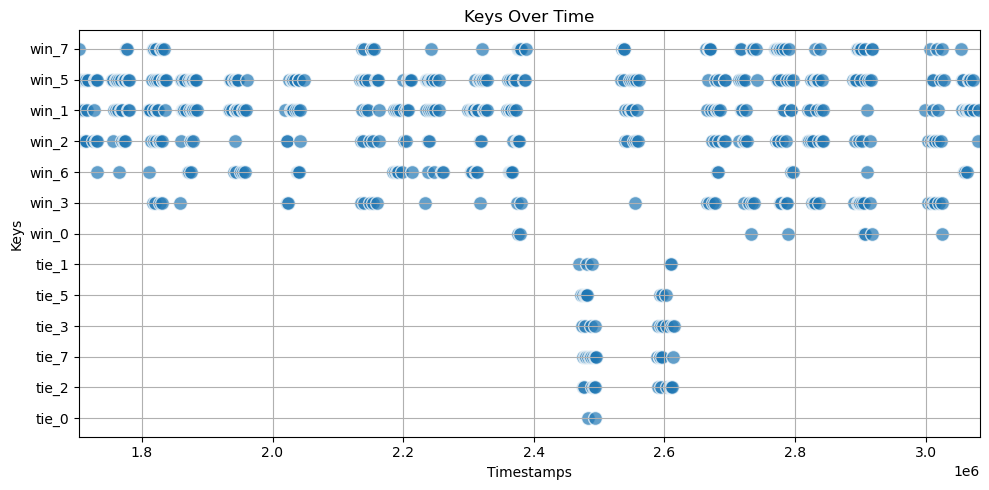

In [50]:
# Prepare the data
timestamps = [int(pair[1]) for pair in all_pairs]  # Start times as integers
labels = [pair[0] for pair in all_pairs]  # Labels (keys) for each timestamp

# Create the plot
plt.figure(figsize=(10, 5))  # Set the size of the plot
plt.scatter(timestamps, labels, alpha=0.7, edgecolors='w', s=100)  # Scatter plot
plt.xlabel('Timestamps')  # Label for the x-axis
plt.ylabel('Keys')  # Label for the y-axis
plt.title('Keys Over Time')  # Title of the plot
plt.xlim(1703995, 3083074)  # Set the x-axis limits

# Improve plot aesthetics
plt.grid(True)  # Enable grid for easier readability
plt.gca().invert_yaxis()  # Optionally invert y-axis if preferred for layout

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()  # Display the plot

In [51]:
all_pairs2 = []
for key, arrays in rec1_ex.items():
    for pair in arrays:
        all_pairs2.append((key, pair[0], pair[1]))  # (key, start, end)

# Sort by start time
all_pairs2.sort(key=lambda x: x[1])

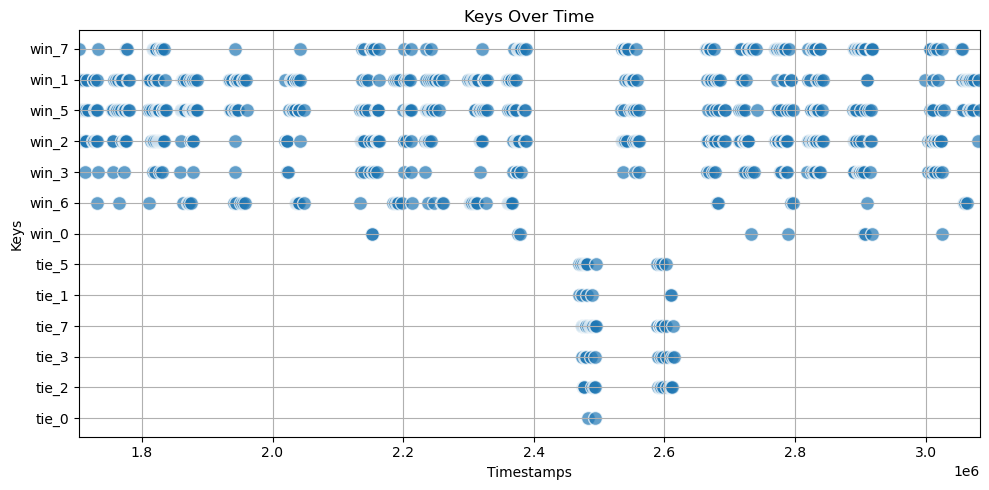

In [52]:
timestamps = [int(pair[1]) for pair in all_pairs2]  # Start times as integers
labels = [pair[0] for pair in all_pairs2]  # Labels (keys) for each timestamp

# Create the plot
plt.figure(figsize=(10, 5))  # Set the size of the plot
plt.scatter(timestamps, labels, alpha=0.7, edgecolors='w', s=100)  # Scatter plot
plt.xlabel('Timestamps')  # Label for the x-axis
plt.ylabel('Keys')  # Label for the y-axis
plt.title('Keys Over Time')  # Title of the plot
plt.xlim(1703995, 3083074)  # Set the x-axis limits

# Improve plot aesthetics
plt.grid(True)  # Enable grid for easier readability
plt.gca().invert_yaxis()  # Optionally invert y-axis if preferred for layout

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()  # Display the plot

In [53]:
all_pairs3 = []
for key, arrays in rec1.items():
    for pair in arrays:
        all_pairs3.append((key, pair[0], pair[1]))  # (key, start, end)

# Sort by start time
all_pairs3.sort(key=lambda x: x[1])

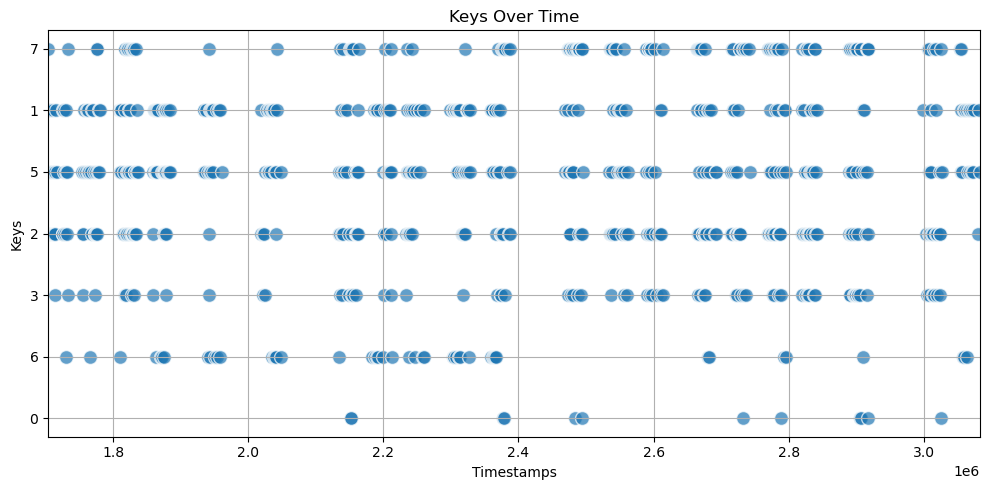

In [54]:
timestamps = [int(pair[1]) for pair in all_pairs3]  # Start times as integers
labels = [pair[0] for pair in all_pairs3]  # Labels (keys) for each timestamp

# Create the plot
plt.figure(figsize=(10, 5))  # Set the size of the plot
plt.scatter(timestamps, labels, alpha=0.7, edgecolors='w', s=100)  # Scatter plot
plt.xlabel('Timestamps')  # Label for the x-axis
plt.ylabel('Keys')  # Label for the y-axis
plt.title('Keys Over Time')  # Title of the plot
plt.xlim(1703995, 3083074)  # Set the x-axis limits

# Improve plot aesthetics
plt.grid(True)  # Enable grid for easier readability
plt.gca().invert_yaxis()  # Optionally invert y-axis if preferred for layout

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()  # Display the plot

In [55]:
differences = []
for i in range(len(all_pairs) - 1):
    current_start = all_pairs[i][1]
    next_start = all_pairs[i+1][1]
    differences.append(next_start - current_start)

# Calculate the median difference
if differences:
    median_difference = np.median(differences)
    print(f"Median difference between consecutive start times: {median_difference}")
else:
    print("No pairs to calculate the difference.")

Median difference between consecutive start times: 901.0


In [56]:
# Window1 Start: 1,703,995
1703995 + 30100

1734095

In [57]:
# Window1 End: 1,734,095
# Window1 Last: 1,733,099
# Window2 Start: 1,754,095

1754095 - 1733099

20996

In [58]:
# Window2_Start - Window1_Last = 20,996
# Median difference: 901.0

1754095+30100

1784195

In [59]:
# Window2 End: 1,784,195
# Window2 Last: 1,783,059
# Window3 Start: 1,809,044

1809044 - 1783059

25985

In [60]:
rce3_alone_clusters

video_name current_subject  \
0   20240320_171038_alone_comp_subj_4-2_and_4-3.1             4.2   
1   20240320_171038_alone_comp_subj_4-2_and_4-3.1             4.3   
2   20240322_120625_alone_comp_subj_3-3_and_3-4.1             3.3   
3   20240322_120625_alone_comp_subj_3-3_and_3-4.1             3.4   
4   20240322_160946_alone_comp_subj_4-3_and_4-4.1             4.3   
5   20240322_160946_alone_comp_subj_4-3_and_4-4.1             4.4   
6   20240323_122227_alone_comp_subj_5-2_and_5-3.1             5.2   
7   20240323_122227_alone_comp_subj_5-2_and_5-3.1             5.3   
8   20240323_144517_alone_comp_subj_3-1_and_3-4.1             3.1   
9   20240323_144517_alone_comp_subj_3-1_and_3-4.1             3.4   
10  20240323_165815_alone_comp_subj_4-2_and_4-4.1             4.2   
11  20240323_165815_alone_comp_subj_4-2_and_4-4.1             4.4   

                            cluster_index_ranges_dict  \
0   {7: [(0, 13), (587, 590), (434, 442), (449, 47...   
1   {7: [(0, 13), (587, 590), (434, 442), (449, 47...   
2   {3: [(66, 105), (242, 267), (412, 418), (174, ...   
3   {3: [(66, 105), (242, 267), (412, 418), (174, ...   
4   {7: [(0, 9), (13, 33), (91, 97), (389, 402), (...   
5   {7: [(0, 9), (13, 33), (91, 97), (389, 402), (...   
6   {7: [(0, 6), (236, 242), (438, 459), (545, 572...   
7   {7: [(0, 6), (236, 242), (438, 459), (545, 572...   
8   {5: [(0, 8), (25, 40), (55, 67), (133, 157), (...   
9   {5: [(0, 8), (25, 40), (55, 67), (133, 157), (...   
10  {5: [(0, 24), (40, 62), (112, 158), (186, 203)...   
11  {5: [(0, 24), (40, 62), (112, 158), (186, 203)...   

                            cluster_times_ranges_dict  \
0   {7: [(1600609, 1601302), (1630059, 1630198), (...   
1   {7: [(1600609, 1601302), (1630059, 1630198), (...   
2   {3: [(1527574, 1529514), (1536374, 1537622), (...   
3   {3: [(1527574, 1529514), (1536374, 1537622), (...   
4   {7: [(1438255, 1438740), (1438878, 1439918), (...   
5   {7: [(1438255, 1438740), (1438878, 1439918), (...   
6   {7: [(1600609, 1600887), (1612389, 1612667), (...   
7   {7: [(1600609, 1600887), (1612389, 1612667), (...   
8   {5: [(1683207, 1683623), (1684455, 1685217), (...   
9   {5: [(1683207, 1683623), (1684455, 1685217), (...   
10  {5: [(1698937, 1699907), (1700531, 1701431), (...   
11  {5: [(1698937, 1699907), (1700531, 1701431), (...   

                       cluster_timestamps_ranges_dict  \
0   {7: [(34079916, 34093775), (34668911, 34671683...   
1   {7: [(34079916, 34093775), (34668911, 34671683...   
2   {3: [(34169998, 34208802), (34346003, 34370949...   
3   {3: [(34169998, 34208802), (34346003, 34370949...   
4   {7: [(34096547, 34106248), (34109019, 34129808...   
5   {7: [(34096547, 34106248), (34109019, 34129808...   
6   {7: [(34070215, 34075759), (34305813, 34311357...   
7   {7: [(34070215, 34075759), (34305813, 34311357...   
8   {5: [(34957172, 34965487), (34982117, 34997362...   
9   {5: [(34957172, 34965487), (34982117, 34997362...   
10  {5: [(36182281, 36201683), (36214156, 36232172...   
11  {5: [(36182281, 36201683), (36214156, 36232172...   

                 trial_cluster_timestamps_ranges_dict  \
0   {'lose_7': [(34079916, 34093775), (34668911, 3...   
1   {'win_7': [(34079916, 34093775), (34668911, 34...   
2   {'tie_3': [(34169998, 34208802), (34346003, 34...   
3   {'tie_3': [(34169998, 34208802), (34346003, 34...   
4   {'tie_7': [(34096547, 34106248), (34109019, 34...   
5   {'tie_7': [(34096547, 34106248), (34109019, 34...   
6   {'lose_7': [(34070215, 34075759), (34305813, 3...   
7   {'win_7': [(34070215, 34075759), (34305813, 34...   
8   {'lose_5': [(34957172, 34965487), (34982117, 3...   
9   {'win_5': [(34957172, 34965487), (34982117, 34...   
10  {'win_5': [(36182281, 36201683), (36214156, 36...   
11  {'lose_5': [(36182281, 36201683), (36214156, 3...   

                      trial_cluster_times_ranges_dict  \
0   {'lose_7': [(1600609, 1601302), (1630059, 1630...   
1   {'win_7': [(1600609, 1601302), (1630059, 16301...   
2 

In [61]:
recordings = spike_analysis.ephyscollection.collection

In [62]:
# Creating a variable of 1 recording
recording_name = '20240320_171038_alone_comp_subj_4-2_t6b6_merged.rec'
recording1 = recordings.get(recording_name)

if recording1 is None:
    print(f"Recording named {recording_name} not found.")
else:
    print(f"Recording {recording_name} successfully retrieved.")

Recording 20240320_171038_alone_comp_subj_4-2_t6b6_merged.rec successfully retrieved.


In [63]:
recording1.unit_firing_rates

{np.int32(9): array([3.33333333, 6.66666667, 6.66666667, ..., 0.        , 0.        ,
        0.        ]),
 np.int32(56): array([ 3.33333333,  3.33333333, 10.        , ...,  0.        ,
         0.        ,  0.        ]),
 np.int32(42): array([0., 0., 0., ..., 0., 0., 0.]),
 np.int32(33): array([0., 0., 0., ..., 0., 0., 0.])}

In [64]:
recording1.unit_timestamps[9][-1]

np.int64(64356167)

In [65]:
recording1.timestamps_var

array([     155,      248,      282, ..., 64383833, 64383856, 64384069])

### Last timestamp of ephys: 64,384,069
### Last timestamp of cluster/20: 3,083,074
### First timestamp of cluster/20: 1,703,995

In [66]:
1703995 / 1000 / 60

28.399916666666666

In [67]:
3083074 / 1000 / 60

51.384566666666665

In [68]:
64384069 / 20

3219203.45

In [69]:
dynamic_windows

[(np.int32(1754095), np.int32(1784095)),
 (np.int32(1809044), np.int32(1839044)),
 (np.int32(1859005), np.int32(1889005))]

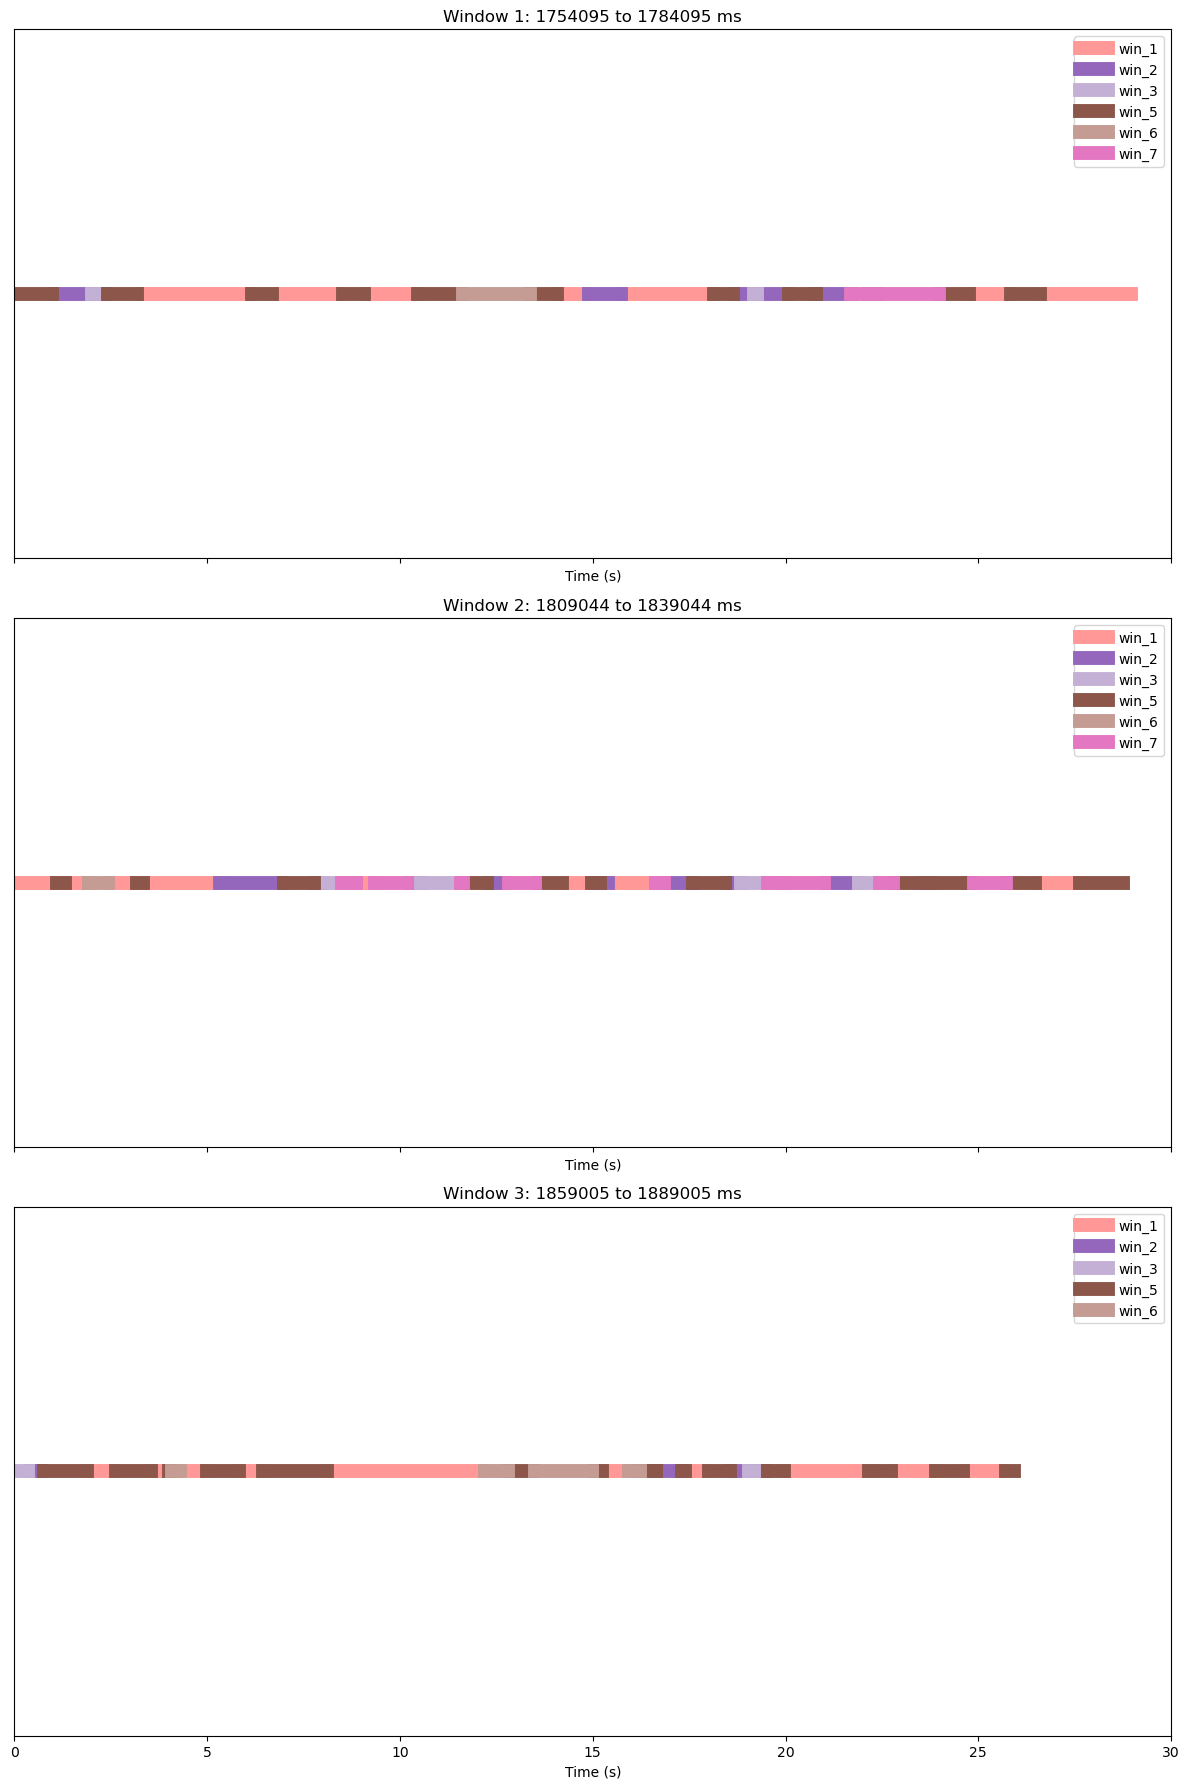

In [70]:
# Function to find the next starting point for the window based on the first timestamp found after a gap
def find_next_start(current_start, all_timestamps, gap):
    # Find the first timestamp after the current start + gap
    for timestamp in sorted(all_timestamps):
        if timestamp > current_start + gap:
            return timestamp
    return None  # Return None if no valid start is found

# Gather all unique keys from rec1_ex
all_keys = sorted(rec1_ex.keys())

# Generate colors for each unique key
cluster_colors = {key: plt.cm.tab20(i % 20) for i, key in enumerate(all_keys)}

# Gather all start timestamps from the categories
all_starts = np.concatenate([np.array(ranges)[:, 0] for ranges in rec1_ex.values()])

# Calculate dynamic windows based on the lowest timestamp and a 30,100 ms gap
dynamic_windows = []
current_start = min(all_starts)
while True:
    next_start = find_next_start(current_start, all_starts, 30100)
    if not next_start:
        break  # Exit the loop if no more windows can be created
    dynamic_windows.append((next_start, next_start + 30000))
    current_start = next_start

# Plotting only the first 3 windows
num_windows_to_plot = min(3, len(dynamic_windows))
fig, axes = plt.subplots(num_windows_to_plot, 1, figsize=(12, 18), sharex=True)

for window_num in range(num_windows_to_plot):
    window_start, window_end = dynamic_windows[window_num]
    ax = axes[window_num]
    data_present = False  # Flag to check if any data is plotted

    for key in all_keys:  # Use the sorted list of keys
        ranges = np.array(rec1_ex[key], dtype=int)
        for start, end in ranges:
            if start < window_end and end > window_start:
                plot_start = (max(start, window_start) - window_start) / 1000  # Converting ms to seconds
                plot_end = (min(end, window_end) - window_start) / 1000
                ax.plot([plot_start, plot_end], [0, 0], marker='|', color=cluster_colors[key], linewidth=10, label=f"{key}")
                data_present = True

    # Setting x-axis in seconds and formatting
    ax.set_xlim(0, 30)
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Window {window_num+1}: {window_start} to {window_end} ms")
    ax.axes.yaxis.set_visible(False)

    # Only show legend if data was present
    if data_present:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # Remove duplicates
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()

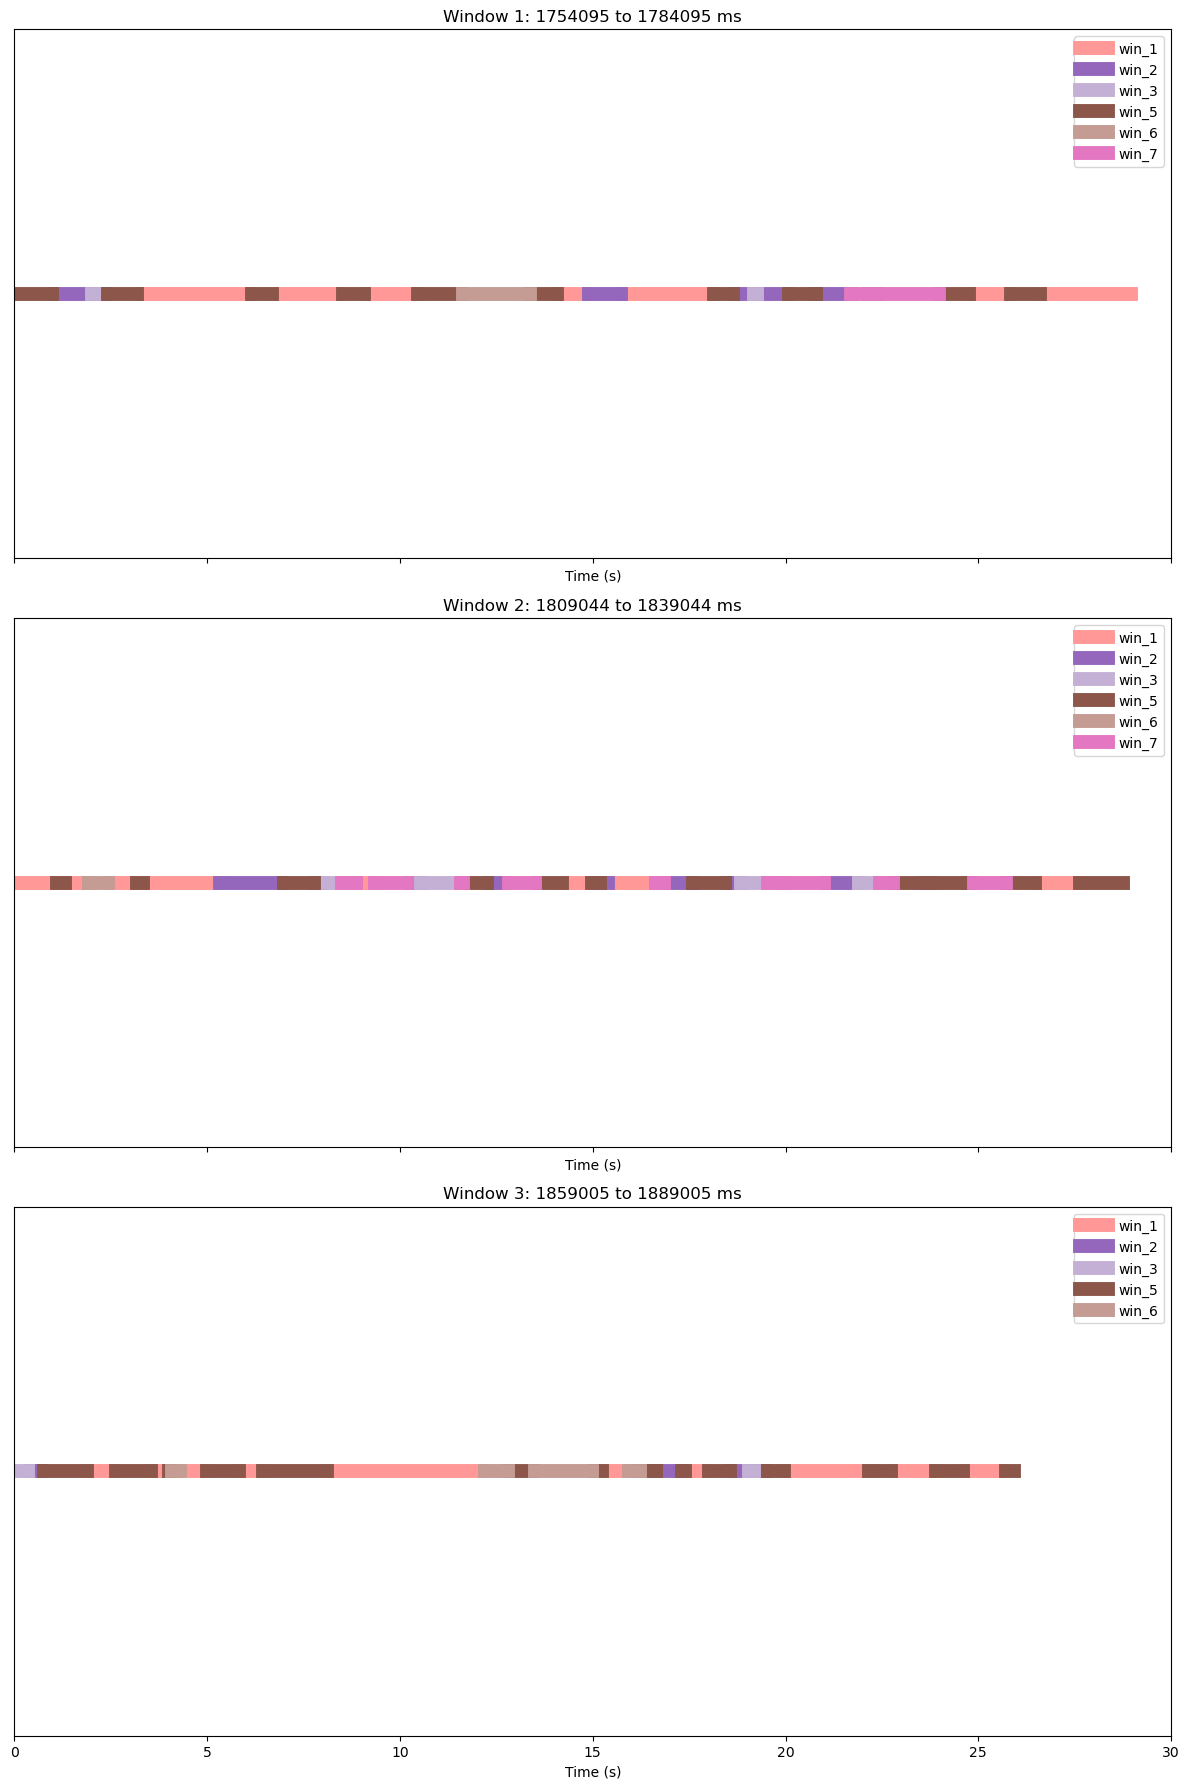

In [71]:
# Gather all unique keys from rec1_ex
all_keys = sorted(rec1_ex.keys())

# Generate colors for each unique key
cluster_colors = {key: plt.cm.tab20(i % 20) for i, key in enumerate(all_keys)}


# Function to find the next starting point for the window based on the first timestamp found after a gap
def find_next_start(current_start, all_timestamps, gap):
    # Find the first timestamp after the current start + gap
    for timestamp in sorted(all_timestamps):
        if timestamp > current_start + gap:
            return timestamp
    return None  # Return None if no valid start is found

# Gather all start timestamps from the categories
all_starts = np.concatenate([np.array(ranges)[:, 0] for ranges in rec1_ex.values()])

# Calculate dynamic windows based on the lowest timestamp and a 30,100 ms gap
dynamic_windows = []
current_start = min(all_starts)
for _ in range(3):
    next_start = find_next_start(current_start, all_starts, 30100)
    if next_start:
        dynamic_windows.append((next_start, next_start + 30000))
        current_start = next_start

# Replot with dynamic windows
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

for window_num, (window_start, window_end) in enumerate(dynamic_windows):
    ax = axes[window_num]
    data_present = False  # Flag to check if any data is plotted

    for key in all_keys:  # Ensure you use the sorted list from earlier
        ranges = np.array(rec1_ex[key], dtype=int)
        for start, end in ranges:
            if start < window_end and end > window_start:
                plot_start = (max(start, window_start) - window_start) / 1000  # Adjusting for milliseconds to seconds
                plot_end = (min(end, window_end) - window_start) / 1000
                ax.plot([plot_start, plot_end], [0, 0], marker='|', color=cluster_colors[key], 
                        linewidth=10, label=f"{key}")
                data_present = True

    # Setting x-axis in seconds and formatting
    ax.set_xlim(0, 30)
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Window {window_num+1}: {window_start} to {window_end} ms")
    ax.axes.yaxis.set_visible(False)

    # Only show legend if data was present
    if data_present:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # Remove duplicates
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()

In [72]:
all_keys = sorted(rec1_ex.keys())
all_keys

['tie_0',
 'tie_1',
 'tie_2',
 'tie_3',
 'tie_5',
 'tie_7',
 'win_0',
 'win_1',
 'win_2',
 'win_3',
 'win_5',
 'win_6',
 'win_7']

In [73]:
all_starts = np.concatenate([np.array(ranges)[:, 0] for ranges in rec1_ex.values()])
all_starts

array([1703995, 1733445, 1775783, 1776546, 1817542, 1818399, 1820616,
       1821864, 1825675, 1828585, 1829070, 1831495, 1833921, 1942711,
       2042286, 2136387, 2140804, 2151354, 2151839, 2153017, 2155304,
       2163550, 2201938, 2211709, 2234506, 2242128, 2321400, 2369074,
       2376142, 2376835, 2378359, 2379953, 2384873, 2387783, 2535656,
       2537388, 2538635, 2543041, 2543763, 2556167, 2664056, 2665096,
       2667590, 2669184, 2670154, 2675698, 2715819, 2717551, 2727183,
       2728292, 2732311, 2733419, 2736330, 2740556, 2769175, 2770561,
       2771946, 2775688, 2777559, 2780262, 2783380, 2784577, 2790032,
       2819482, 2825718, 2827381, 2829945, 2838260, 2838815, 2889676,
       2890300, 2891339, 2894111, 2897021, 2898965, 2901248, 2906237,
       2907346, 2916008, 2917047, 2917809, 3006436, 3007059, 3014681,
       3017869, 3025561, 3054040, 3055426, 1704758, 1707114, 1711479,
       1716330, 1726446, 1726793, 1730743, 1757351, 1760816, 1763241,
       1768161, 1769

In [74]:
dynamic_windows = []
current_start = min(all_starts)
current_start

np.int32(1703995)

In [75]:
for _ in range(3):
    for timestamp in sorted(all_starts):
        if timestamp > current_start + 301000:
            next_start = timestamp
        else:
            next_start = None

timestamp

np.int32(3083074)

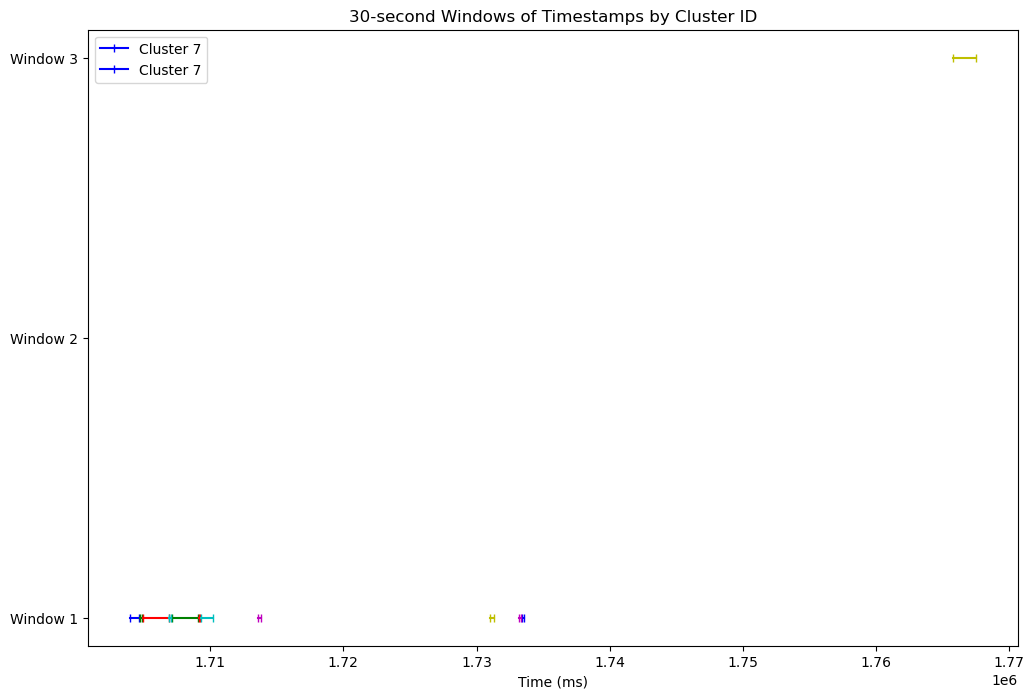

(np.int64(1703995),
 [(np.int64(1703995), np.int64(1733995)),
  (np.int64(1733995), np.int64(1763995)),
  (np.int64(1763995), np.int64(1793995))])

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data structure received
rec1 = {
    '7': np.array([[1703995, 1704688],
                   [1733445, 1733584],
                   [3055426, 3055428]]),
    '1': np.array([[1704758, 1704896],
                   [1707114, 1709123],
                   [3081480, 3083074]]),
    '5': np.array([[1704965, 1706906],
                   [1709192, 1709262],
                   [3083074, 3083315]]),
    '2': np.array([[1706906, 1707044],
                   [1709331, 1710232],
                   [3080510, 3081480]]),
    '3': np.array([[1713627, 1713835],
                   [1733168, 1733376],
                   [3024452, 3024868]]),
    '6': np.array([[1731020, 1731297],
                   [1765736, 1767468],
                   [3063464, 3064088]]),
    '0': np.array([[2151562, 2151770],
                   [2152740, 2152948],
                   [3024868, 3025561]])
}

# Finding the lowest timestamp
min_timestamp = min(min(ranges[:, 0]) for ranges in rec1.values())

# Defining three consecutive 30-second windows from the lowest timestamp
windows = [(min_timestamp + i * 30000, min_timestamp + (i + 1) * 30000) for i in range(3)]

# Prepare for plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Colors for different cluster ids
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for idx, (key, ranges) in enumerate(rec1.items()):
    for start, end in ranges:
        for window_num, (window_start, window_end) in enumerate(windows):
            # Check if the timestamp range falls within the current window
            if start < window_end and end > window_start:
                # Adjust the start and end to fit within the window for visualization
                plot_start = max(start, window_start)
                plot_end = min(end, window_end)
                # Plotting the range
                ax.plot([plot_start, plot_end], [window_num, window_num], marker='|', color=colors[idx % len(colors)],
                        label=f"Cluster {key}" if window_num == 0 and idx == 0 else "")

# Formatting the plot
ax.set_yticks(range(3))
ax.set_yticklabels([f"Window {i+1}" for i in range(3)])
ax.set_xlabel("Time (ms)")
ax.set_title("30-second Windows of Timestamps by Cluster ID")
ax.legend()
plt.show()

# Return the minimum timestamp for verification
min_timestamp, windows


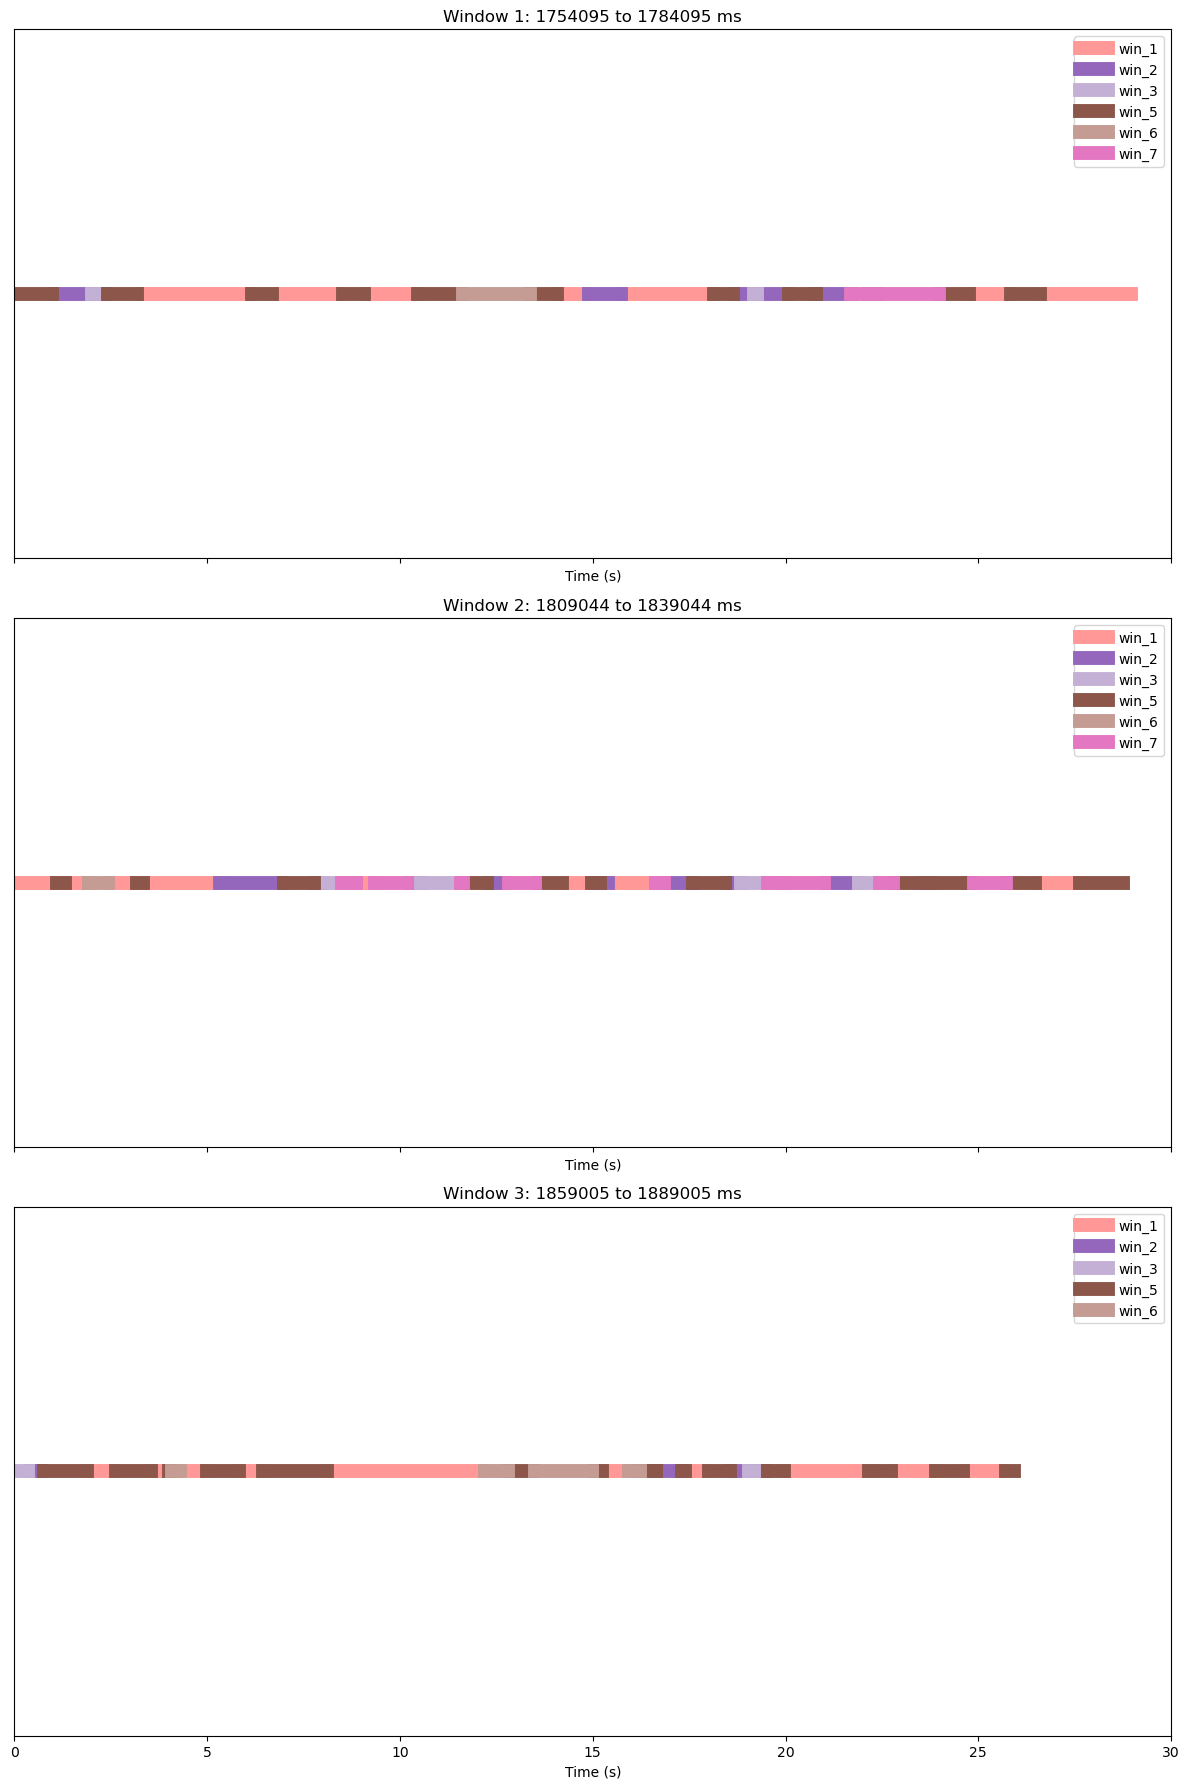

In [77]:
def find_next_start(current_start, all_timestamps, gap):
    # Find the first timestamp after the current start + gap
    for timestamp in sorted(all_timestamps):
        if timestamp > current_start + gap:
            return timestamp
    return None  # Return None if no valid start is found

for _ in range(3):
    next_start = find_next_start(current_start, all_starts, 30100)
    if next_start:
        dynamic_windows.append((next_start, next_start + 30000))
        current_start = next_start

# Replot with dynamic windows
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

for window_num, (window_start, window_end) in enumerate(dynamic_windows):
    ax = axes[window_num]
    data_present = False  # Flag to check if any data is plotted

    for key in all_keys:  # Ensure you use the sorted list from earlier
        ranges = np.array(rec1_ex[key], dtype=int)
        for start, end in ranges:
            if start < window_end and end > window_start:
                plot_start = (max(start, window_start) - window_start) / 1000  # Adjusting for milliseconds to seconds
                plot_end = (min(end, window_end) - window_start) / 1000
                ax.plot([plot_start, plot_end], [0, 0], marker='|', color=cluster_colors[key], 
                        linewidth=10, label=f"{key}")
                data_present = True

    # Setting x-axis in seconds and formatting
    ax.set_xlim(0, 30)
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Window {window_num+1}: {window_start} to {window_end} ms")
    ax.axes.yaxis.set_visible(False)

    # Only show legend if data was present
    if data_present:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # Remove duplicates
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()